# **Network Position and Inventive Advantage: A Generative AI Patent Study**

## **Objectives**

* To investigate how network position within the innovation space influences inventive advantage in generative AI patenting.
* To construct a generative AI innovation space—using semantic embeddings and patent metadata—and trace its temporal shifts to reveal emerging technological trajectories and actor positions.
* To identify the key technological, organizational, and geographical factors that confer sustainable competitive advantage in the generative AI field.

## **Problem Statement**

* Conventional patent‐metric analyses inadequately capture latent semantic relationships and collaboration structures in the rapidly evolving LLM domain.
* South Korea’s inventive output, though significant, risks marginalization within larger national clusters.
* A hybrid embedding‐network approach is needed to (i) surface nuanced positional insights and (ii) reveal collaboration dynamics that traditional counts or citation tallies overlook.
* Technically, representing long patent texts in vector space is constrained by the model’s maximum token limit.

## **Methodology**

### Vector Embedding & Patent Classification
* Embed each patent’s title, abstract, and claims using a Sentence‑BERT model (for example, PatentBERTa)
* Train a balanced‑weight logistic regression (with an optional MLP) on those embeddings.
* Evaluate performance with accuracy, F1 score, classification reports, and confusion matrices.

### Dimensionality Reduction (2D) & Invention Space
* Reduce patent embeddings to two dimensions using t‑SNE 
* Produce fixed‑axis scatterplots that show global patent distributions in space alongside highlighted Korean core versus peripheral patents.

### Co‑Inventor Network Analysis
* Extract inventors from LLM‑related patents (Generative AI)
* Construct an undirected weighted graph where edges reflect co‑filing frequency
* Select the top 1000 inventors by weighted degree
* Visualize the network with country‑coded nodes and edge thickness proportional to collaboration intensity.

# **1. Install packages**

## **1-(1) Install packages**

In [1]:
# Colab Shortcuts
# Ctrl + S    : Save notebook
# Ctrl + Enter    : Run current cell
# Ctrl + Shift + Enter    : Run selected code only
# Ctrl + F9    : Run all cells
# Ctrl + F8    : Run all cells above and including current
# Ctrl + F10   : Run current cell and all cells below
# Ctrl + /    : Toggle comment on selected lines

In [3]:
import sys
!"{sys.executable}" -m pip install pandas numpy networkx matplotlib python-louvain pyvis pycountry rapidfuzz adjustText tqdm


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 756.0/756.0 kB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ----------- ---------------------------- 1.8/6.3 MB 9.1 MB/s eta 0:00:01
   -------------------------- ------------- 4.2/6.3 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  6.3/6.3 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 10.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 10.7 MB/s eta 0:00:00
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9402 sha256=2f02c3d316860cc8616c6946d547b02b3b14beb3540df24b

  DEPRECATION: Building 'python-louvain' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'python-louvain'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [5]:
# Install required packages (run once at the start)
!pip install pandas numpy networkx matplotlib python-louvain pyvis pycountry rapidfuzz adjustText tqdm

Access is denied.


In [3]:
# # 1. Mount Google Drive (to read/write files)
# from google.colab import drive
# drive.mount('/content/drive')  # mounts your Drive at /content/drive
# # 2. Set the data directory path
# base_dir = '/content/drive/MyDrive/data1'  # path where the CSV files are stored

## **1-(2) Library Import**

In [6]:
# Press Ctrl + F10 to run all cells from this one; for more shortcuts, click Runtime at the top
import os
import re               # regular expressions
import time  
import torch
import numpy as np  # Array operations
import pandas as pd  # DataFrame operations
import seaborn as sns          # Seaborn: statistical data visualization
import pycountry               # pycountry: ISO country code and information
import networkx as nx          # NetworkX: network analysis

from glob import glob      # glob: utility for file pattern matching

from sklearn.model_selection import train_test_split  # Train/test splitting
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt  # Matplotlib: MATLAB‑style 2D plotting
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib.lines import Line2D

from adjustText import adjust_text
from itertools import combinations



ModuleNotFoundError: No module named 'torch'

# **2. Data Preparation**

## **2-(1)  List and filter CSV files**

In [5]:
# Cell 2-(1): List and filter CSV files

base_dir = 'E:/data1'  # base_dir: path to the data folder

# Tuple of prefixes to select files starting with '43', '44', etc.
prefixes = ('1', '3','4', '5', '6', '7', '8', '9')
# prefixes = ('3', '4')

# Gather all .csv file paths under base_dir
all_csv = glob(os.path.join(base_dir, '*.csv'))  # os.path.join: join directory and pattern

# Filter files whose basename starts with any of the specified prefixes
csv_files = [
    f for f in all_csv
    if os.path.basename(f).startswith(prefixes)
]

# Print the number of files found and their basenames
print(f'Found {len(csv_files)} files:')
for f in csv_files:
    print('  -', os.path.basename(f))


Found 97 files:
  - 15.Neural networks (11).csv
  - 15.Neural networks (12).csv
  - 15.Neural networks (13).csv
  - 15.Neural networks (14).csv
  - 15.Neural networks (15).csv
  - 15.Neural networks (16).csv
  - 15.Neural networks (17).csv
  - 15.Neural networks (18).csv
  - 15.Neural networks (19).csv
  - 15.Neural networks (20).csv
  - 15.Neural networks (21).csv
  - 15.Neural networks (22).csv
  - 15.Neural networks (23).csv
  - 15.Neural networks (24).csv
  - 15.Neural networks (25).csv
  - 15.Neural networks (26).csv
  - 15.Neural networks (27).csv
  - 15.Neural networks (28).csv
  - 17.Reinforcement learning.csv
  - 36.NLP_1.csv
  - 36.NLP_2.csv
  - 37.Diaglogue.csv
  - 38.IE.csv
  - 39.MachineTranslation.csv
  - 40.Morphology.csv
  - 41.NLG.csv
  - 42.NLP(General)_1.csv
  - 42.NLP(General)_2.csv
  - 42.NLP(General)_3.csv
  - 42.NLP(General)_4.csv
  - 43.Semantics.csv
  - 44.SentimentAnalysis.csv
  - 53.Speech-to-Speech.csv
  - 54.SpeechSynthesis.csv
  - 6.Machine Learning (1).cs

## **2-(2) Load CSV Files and Remove Duplicates**

In [6]:
# Cell 2-(2): Read CSV files and remove duplicates

df_list = []  # List to hold individual CSV DataFrames

# Attempt to read each file using various encodings
for f in csv_files:
    for enc in ('utf-8', 'cp949', 'latin1'):
        try:
            # Read the CSV with the specified encoding
            df = pd.read_csv(f, encoding=enc)
            print(f'{os.path.basename(f)} read successfully (encoding={enc})')
            df_list.append(df)  # Add the read DataFrame to the list
            break               # Move to the next file on success
        except Exception:
            continue            # Try the next encoding on failure

# Concatenate all DataFrames and drop exact duplicate rows
combined_df = pd.concat(df_list, ignore_index=True).drop_duplicates()
print(f'Total rows after merging: {len(combined_df)}')


15.Neural networks (11).csv read successfully (encoding=cp949)
15.Neural networks (12).csv read successfully (encoding=cp949)
15.Neural networks (13).csv read successfully (encoding=cp949)
15.Neural networks (14).csv read successfully (encoding=cp949)
15.Neural networks (15).csv read successfully (encoding=cp949)
15.Neural networks (16).csv read successfully (encoding=cp949)
15.Neural networks (17).csv read successfully (encoding=cp949)
15.Neural networks (18).csv read successfully (encoding=cp949)
15.Neural networks (19).csv read successfully (encoding=cp949)
15.Neural networks (20).csv read successfully (encoding=cp949)
15.Neural networks (21).csv read successfully (encoding=cp949)
15.Neural networks (22).csv read successfully (encoding=cp949)
15.Neural networks (23).csv read successfully (encoding=cp949)
15.Neural networks (24).csv read successfully (encoding=cp949)
15.Neural networks (25).csv read successfully (encoding=cp949)
15.Neural networks (26).csv read successfully (encoding

In [7]:
combined_df.shape  # DataFrame

(399019, 45)

## **2-(3) Column Name Mapping (Korean → English)**

In [8]:
# Cell 3: Column name mapping (Korean → English)
import pandas as pd  # Use pandas for DataFrame operations

# 1) Apply column mapping to combined_df
orig = combined_df.columns.tolist()  # List of original column names

# List of new English column names with bilingual comments for each
new = [
    "PTO_id",                 # 국가코드 (Country code)
    "PTO_type",               # DB종류 (Database type)
    "patent_kind",            # 특허/실용 구분 (Patent vs utility model)
    "pub_type_code",          # 문헌종류 코드 (Publication type code)
    "title",                  # 발명의 명칭 (Invention title)
    "title_en",               # 발명의 명칭-번역문 (Invention title – translation)
    "abstract",               # 요약 (Abstract)
    "abstract_en",            # 요약-번역문 (Abstract – translation)
    "claim_main",             # 대표청구항 (Main claim)
    "claim_main_en",          # 대표청구항-번역문 (Main claim – translation)
    "claims_indep",           # 독립청구항[KR,JP,US,CN,EP,IN] (Independent claims [KR, JP, US, CN, EP, IN])
    "claims_indep_en",        # 독립청구항-번역문[JP,US,CN,EP] (Independent claims – translation [JP, US, CN, EP])
    "num_claims",             # 청구항 수 (Number of claims)
    "appl_id",                # 출원번호 (Application number)
    "appl_date",              # 출원일 (Application date)
    "pub_id",                 # 공개번호 (Publication number)
    "pub_date",               # 공개일 (Publication date)
    "grant_id",               # 등록번호 (Grant number)
    "grant_date",             # 등록일 (Grant date)
    "applicant",              # 출원인 (Applicant)
    "inventor",               # 발명자 (Inventor)
    "citations_count",        # 인용 문헌 수(B1) (Citations count (B1))
    "citation_ids",           # 인용 문헌번호(B1) (Citation IDs (B1))
    "cited_by_count",         # 피인용 문헌 수(F1) (Cited-by count (F1))
    "cited_by_ids",           # 피인용 문헌번호(F1) (Cited-by IDs (F1))
    "wips_family_id",         # WIPS패밀리 ID (WIPS family ID)
    "wips_family_pub_ids",    # WIPS패밀리 문헌번호(출원기준) (WIPS family publication IDs)
    "wips_family_pub_count",  # WIPS패밀리 문헌 수(출원기준) (WIPS family publication count)
    "status_info",            # 상태정보[KR,JP,US,EP,CN,CA,AU] (Status info [KR, JP, US, EP, CN, CA, AU])
    "current_owner",          # 현재권리자[KR,JP,US,CN,CA,AU] (Current owner [KR, JP, US, CN, CA, AU])
    "num_applicants",         # 출원인 수 (Number of applicants)
    "applicant_nat",          # 출원인 국적 (Applicant nationality)
    "applicant_main_code",    # 출원인 대표명화 코드 (Applicant main name code)
    "applicant_main_name_en", # 출원인 대표명화 영문명 (Applicant main name – English)
    "inventor_nat",           # 발명자 국적 (Inventor nationality)
    "num_inventors",          # 발명자 수 (Number of inventors)
    "cpc_main",               # Current CPC Main
    "cpc_all",                # Current CPC All
    "ipc_main",               # Current IPC Main
    "ipc_all",                # Current IPC All
    "orig_cpc_main",          # Original CPC Main
    "orig_cpc_all",           # Original CPC All
    "orig_ipc_main",          # Original IPC Main
    "orig_ipc_all",           # Original IPC All
    "wintelips_key"           # Wintelips key
]

# Verify that the number of original and new column names match
assert len(orig) == len(new), "Mismatch in number of columns"

# Apply the new column names
combined_df.columns = new

# 2) Sort combined_df by 'inventor_nat' in descending order and reset index
if 'inventor_nat' in combined_df.columns:
    combined_df = (
        combined_df
        .sort_values(by='inventor_nat', ascending=False)
        .reset_index(drop=True)
    )
else:
    combined_df = combined_df.copy()

In [9]:
# Check the results
display(combined_df[['appl_id', 'applicant', 'applicant_nat', 'inventor', 'inventor_nat', 'cited_by_count', 'appl_date']].head(1))

appl_id applicant applicant_nat  \
0  0276049       NaN           NaN   

                                            inventor inventor_nat  \
0  MOTES-CONNERS, CORROLL J. | SATTERWHITE, LAWRE...      ZZ | ZZ   

   cited_by_count appl_date  
0             NaN       NaN

In [10]:
len(combined_df)

399019

## **2-(4) Parse Dates and Create Year**

In [11]:
# Cell 2-(4): Parse dates and create year column

from dateutil import parser  # Parser supporting various date formats

# 1) Define parse_date function
def parse_date(x):
    try:
        return parser.parse(x, dayfirst=True)
    except:
        return pd.NaT
# 2) Convert appl_date strings to datetime
combined_df['appl_date_parsed'] = (
    combined_df['appl_date']
      .astype(str)
      .str.strip()
      .map(parse_date)
)
# 3) Create year column
combined_df['year'] = combined_df['appl_date_parsed'].dt.year

In [12]:
# Intermediate check
display(
    combined_df[
        [
            'appl_id',            # 출원번호 (Application number)
            'applicant',          # 출원인 (Applicant)
            'applicant_nat',      # 출원인 국적 (Applicant nationality)
            'inventor',           # 발명자 (Inventor)
            'inventor_nat',       # 발명자 국적 (Inventor nationality)
            'cited_by_count',     # 피인용 문헌 수 (Cited-by count)
            'appl_date',          # 출원일 (Application date)
            'appl_date_parsed',   # 파싱된 출원일 (Parsed application date)
            'year'                # 연도 (Year)
        ]
    ].head(1)
)

appl_id applicant applicant_nat  \
0  0276049       NaN           NaN   

                                            inventor inventor_nat  \
0  MOTES-CONNERS, CORROLL J. | SATTERWHITE, LAWRE...      ZZ | ZZ   

   cited_by_count appl_date appl_date_parsed  year  
0             NaN       NaN              NaT   NaN

## **2-(5) Generate country_code, invs, and nats_raw**

In [13]:
# Cell 2-(5): Generate country_code, invs, and nats_raw columns
import numpy as np

# 1) country_code: first two characters of applicant_nat, uppercase
combined_df['country_code'] = (
    combined_df['applicant_nat']
      .fillna('')           # NaN → '' (replace missing with empty string)
      .astype(str)          # Convert to string
      .str[:2]              # Select first two characters
      .str.upper()          # Convert to uppercase
)

# 2) invs: split inventor by '|' into a list of trimmed names
combined_df['invs'] = (
    combined_df['inventor']
      .fillna('')           # NaN → ''
      .astype(str)          # Convert to string
      .str.split('|')       # Split on '|'
      .apply(
          lambda lst: [
              s.strip() for s in lst if s.strip() != ''
          ]
      )                     # Trim whitespace and remove empty strings
)

# 3) nats_raw: extract two-letter codes from inventor_nat
combined_df['nats_raw'] = (
    combined_df['inventor_nat']
      .fillna('')           # NaN → ''
      .astype(str)          # Convert to string
      .str.findall(r'[A-Za-z]{2}')  # Find all two-letter sequences
      .apply(lambda lst: [s.upper() for s in lst])  # Uppercase each code
)

In [14]:
# Intermediate check
# 1) country_code: first two letters of applicant_nat, uppercase
# 2) invs: split inventor column by '|' into a list
# 3) nats_raw: extract two-letter codes from inventor_nat
display(
    combined_df[
        [
            'appl_id',       # 출원번호 (Application number)
            'year',          # 연도 (Year)
            'applicant',     # 출원인 (Applicant)
            'applicant_nat', # 출원인 국적 (Applicant nationality)
            'country_code',  # 국가코드 (Country code)
            'inventor',      # 발명자 (Inventor)
            'invs',          # 발명자 리스트 (Inventor list)
            'inventor_nat',  # 발명자 국적 (Inventor nationality)
            'nats_raw'       # 원시 국적 코드 (Raw nationality codes)
        ]
    ].head(1)
)

appl_id  year applicant applicant_nat country_code  \
0  0276049   NaN       NaN           NaN                

                                            inventor  \
0  MOTES-CONNERS, CORROLL J. | SATTERWHITE, LAWRE...   

                                                invs inventor_nat  nats_raw  
0  [MOTES-CONNERS, CORROLL J., SATTERWHITE, LAWRE...      ZZ | ZZ  [ZZ, ZZ]

## **2-(6) Define the align_nats function**

In [15]:
# Cell 2-(6) : Define the align_nats function
def align_nats(inv_list, nat_list, cc):
    inv_len = len(inv_list)
    v = list(nat_list)
    # a) If the nationality list is empty, fill all entries with country_code
    if len(v) == 0:
        v = [cc] * inv_len
    # b) If there are fewer nationalities than inventors, pad the remainder with country_code
    elif len(v) < inv_len:
        v += [cc] * (inv_len - len(v))
    # c) If there are more nationalities than inventors, truncate to match inv_list length
    elif len(v) > inv_len:
        v = v[:inv_len]
    return v

## **2-(7) Create 'nats' list for each row**

In [16]:
# Cell 2-(7): Create 'nats' list for each row (apply correction logic)
combined_df['nats'] = combined_df.apply(
    lambda row: align_nats(
        row['invs'],         # invs: inventor list (발명자 리스트)
        row['nats_raw'],     # nats_raw: raw nationality codes (원시 국적 코드)
        row['country_code']  # country_code: applicant country code (출원인 국가코드)
    ),
    axis=1
)  # nats: adjusted nationality list (보정된 국적 리스트)

In [17]:
# Intermediate check
# 1) country_code: first two letters of applicant_nat, uppercase
# 2) invs: split inventor column by '|' into a list
# 3) nats_raw: extract two-letter codes from inventor_nat
# 4) nats: apply alignment corrections to nationality list
display(
    combined_df[
        [
            'appl_id',         # 출원번호 (Application number)
            'year',            # 연도 (Year)
            'applicant_nat',   # 출원인 국적 (Applicant nationality)
            'country_code',    # 국가코드 (Country code)
            'inventor',        # 발명자 (Inventor)
            'invs',            # 발명자 리스트 (Inventor list)
            'num_inventors',   # 발명자 수 (Number of inventors)
            'inventor_nat',    # 발명자 국적 (Inventor nationality)
            'nats_raw',        # 원시 국적 코드 (Raw nationality codes)
            'nats'             # 보정된 국적 리스트 (Adjusted nationality list)
        ]
    ].head(1)
)

appl_id  year applicant_nat country_code  \
0  0276049   NaN           NaN                

                                            inventor  \
0  MOTES-CONNERS, CORROLL J. | SATTERWHITE, LAWRE...   

                                                invs  num_inventors  \
0  [MOTES-CONNERS, CORROLL J., SATTERWHITE, LAWRE...            2.0   

  inventor_nat  nats_raw      nats  
0      ZZ | ZZ  [ZZ, ZZ]  [ZZ, ZZ]

# **3. Create Exploded DataFrame**

## **3-(1) Generate exploded data (df_expl)**

In [18]:
# Cell 3-(1): Generate Exploded DataFrame (expl from combined_df)
# 1) Explode 'invs' and 'nats' lists into tidy format
df_expl = (
    combined_df
      .explode(['invs', 'nats'])
      .rename(columns={
          'invs': 'inventor_pre',
          'nats': 'inventor_nat_pre'
      })
)

# 2) Create 'inventor_nat': replace empty strings or NaN with 'country_code'
df_expl['inventor_nat'] = (
    df_expl['inventor_nat_pre']
      .replace('', np.nan)
      .fillna(df_expl['country_code'])
)

# 3) Create 'inventor': use pre-adjustment inventor (or apply further processing)
#    here, assign 'inventor_pre' directly
df_expl['inventor'] = df_expl['inventor_pre']

# 4) Finalise: drop original temporary columns
df_expl = df_expl.drop(columns=['inventor_pre', 'inventor_nat_pre'])

## **3-(2): Normalize inventor names**

In [19]:
# Cell 3-(2): Normalize inventor names (uppercase, whitespace cleanup, remove punctuation)
import re

# 1) Preserve original inventor column in 'inventor_pre'
#    원본 inventor 컬럼을 inventor_pre에 보존 (Preserve original inventor column in inventor_pre)
df_expl['inventor_pre'] = df_expl['inventor']

# 2) Define normalization function
#    - Remove periods and commas
#    - Collapse multiple spaces into one
#    - Convert to uppercase
def normalize_name(x: str) -> str:
    if not isinstance(x, str):
        return ''
    # Remove punctuation (periods and commas)
    s = re.sub(r'[.,]', '', x)
    # Collapse multiple spaces into a single space and trim
    s = re.sub(r'\s+', ' ', s).strip()
    # Convert to uppercase
    return s.upper()

# 3) Apply normalization: overwrite 'inventor' column
#    정규화 적용: 기존 inventor 컬럼을 덮어쓰기 (Apply normalization by overwriting the inventor column)
df_expl['inventor'] = df_expl['inventor_pre'].apply(normalize_name)


In [20]:
len(df_expl)

1569671

## **3-(3): Split applicant information and explode**

In [21]:
# # Cell 3-(3a): Backup/Rename Applicant and Normalize Nationality Column

# import re
# import pandas as pd

# # 1) Backup original applicant column and use main name where available
# df_expl = df_expl.rename(
#     columns={
#         'applicant': 'applicant_pre',
#         'applicant_main_name_en': 'applicant'
#     }
# )
# df_expl['applicant'] = df_expl['applicant'].fillna(df_expl['applicant_pre']).replace('', pd.NA)

# # 2) Resolve applicant_nat columns
# #    Strip whitespace from column names first
# df_expl.columns = df_expl.columns.str.strip()
# nat_cols = [c for c in df_expl.columns if c == 'applicant_nat']

# if not nat_cols:
#     df_expl['applicant_nat'] = df_expl.get('country_code', pd.NA)
#     df_expl['applicant_nat_pre'] = df_expl['applicant_nat']
# elif len(nat_cols) == 1:
#     df_expl['applicant_nat_pre'] = df_expl['applicant_nat']
# else:
#     main, backup = nat_cols[:2]
#     df_expl['applicant_nat_pre'] = df_expl[backup]
#     df_expl['applicant_nat']     = df_expl[main]

# # 3) Backfill nationality from country_code
# df_expl['applicant_nat'] = df_expl['applicant_nat'].fillna(df_expl.get('country_code', pd.NA))


In [22]:
# # Cell 3-(3b): Explode Applicants and Normalize Organization Names

# # 1) Define helper functions
# def split_and_clean(s):
#     if pd.isna(s):
#         return []
#     return [p.strip() for p in str(s).split('|') if p.strip()]

# def pad_list(lst, n, fill):
#     if len(lst) >= n:
#         return lst[:n]
#     pad_val = lst[0] if lst else fill
#     return lst + [pad_val] * (n - len(lst))

# def norm_org(name):
#     cleaned = re.sub(r'[.,]', '', str(name))
#     cleaned = re.sub(r'\s+', ' ', cleaned)
#     return cleaned.upper().strip()

# # 2) Split applicant names and nationalities into lists
# df_expl['app_names'] = df_expl['applicant'].apply(split_and_clean)
# df_expl['app_nats']  = df_expl['applicant_nat'].apply(split_and_clean)

# # 3) Pad nationality lists to match name lengths
# df_expl['app_nats'] = df_expl.apply(
#     lambda row: pad_list(row['app_nats'], len(row['app_names']), row.get('country_code', 'UN')),
#     axis=1
# )

# # 4) Explode into one row per (applicant, nationality)
# df_expl = (
#     df_expl
#       .explode(['app_names', 'app_nats'])
#       .rename(columns={'app_names': 'applicant', 'app_nats': 'applicant_nat'})
# )

# # 5) Normalize organization names and clean up
# df_expl['applicant'] = df_expl['applicant'].apply(norm_org)

# # 6) Drop temporary columns and remove duplicates
# df_expl = df_expl.drop(columns=['applicant_pre'], errors='ignore')
# df_expl = df_expl.loc[:, ~df_expl.columns.duplicated()]


In [23]:
# Cell 3-(3): Split applicant information and explode (use df_expl)
# 1) Backup original applicant and set main applicant column
df_expl.rename(
    columns={
        'applicant': 'applicant_pre',           # 기존 applicant → applicant_pre (backup original applicant)
        'applicant_main_name_en': 'applicant'   # applicant_main_name_en → main applicant column
    },
    inplace=True
)
# Use applicant_pre to fill NaN in the new applicant column
df_expl['applicant'] = df_expl['applicant'].combine_first(df_expl['applicant_pre'])

# 1-1) Also replace empty strings with NA, then backfill
df_expl['applicant'] = df_expl['applicant'].replace('', pd.NA)
df_expl['applicant'] = df_expl['applicant'].combine_first(df_expl['applicant_pre'])

# 2) Resolve duplicate applicant_nat columns
df_expl.rename(columns=lambda c: c.strip(), inplace=True)  # Remove whitespace from column names
nat_cols = [c for c in df_expl.columns if c == 'applicant_nat']

if not nat_cols:
    # If no applicant_nat column exists
    df_expl['applicant_nat']     = df_expl.get('country_code', pd.NA)
    df_expl['applicant_nat_pre'] = df_expl['applicant_nat']
elif len(nat_cols) == 1:
    # If exactly one applicant_nat column
    df_expl['applicant_nat_pre'] = df_expl['applicant_nat']
else:
    # If multiple applicant_nat columns
    main, backup = nat_cols[:2]                               # First is main, second is backup
    df_expl['applicant_nat_pre'] = df_expl[backup]          # Backup values
    df_expl['applicant_nat']     = df_expl[main]            # Main values

# Backfill missing applicant_nat from country_code
if 'country_code' in df_expl:
    df_expl['applicant_nat'].fillna(df_expl['country_code'], inplace=True)

# 3) Define and apply split-and-clean function for '|' separated strings
def split_and_clean(s):
    if pd.isna(s):
        return []
    return [p.strip() for p in str(s).split('|') if p.strip()]

df_expl['app_names'] = df_expl['applicant'].apply(split_and_clean)
df_expl['app_nats']  = df_expl['applicant_nat'].apply(split_and_clean)

# 4) Define and apply padding function to match list lengths
def pad_list(lst, n, fill):
    if len(lst) >= n:
        return lst[:n]
    pad_val = lst[0] if lst else fill
    return lst + [pad_val] * (n - len(lst))

df_expl['app_nats'] = df_expl.apply(
    lambda r: pad_list(r['app_nats'], len(r['app_names']), r.get('country_code', 'UN')),
    axis=1
)

# 5) Explode lists and clean up column names
df_expl = (
    df_expl
      .drop(columns=['applicant'], errors='ignore')  # Remove old applicant column
      .explode(['app_names', 'app_nats'])            # Explode list columns into rows
      .rename(columns={'app_names': 'applicant',     # app_names → applicant
                       'app_nats': 'applicant_nat'}) # app_nats → applicant_nat
)

# 6) Normalize organization names (uppercase, remove punctuation, cleanup spaces)
def norm_org(x):
    s = re.sub(r'[.,]', '', str(x))     # Remove periods and commas
    s = re.sub(r'\s+', ' ', s)          # Collapse multiple spaces into one
    return s.upper().strip()            # Convert to uppercase and trim

df_expl['applicant'] = df_expl['applicant'].apply(norm_org)

# 7) Remove temporary and duplicate columns
df_expl.drop(columns=['applicant_pre'], errors='ignore', inplace=True)  # Remove backup column
df_expl = df_expl.loc[:, ~df_expl.columns.duplicated()]              # Drop duplicated columns

C:\Users\user\AppData\Local\Temp\ipykernel_22604\1030852468.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_expl['applicant_nat'].fillna(df_expl['country_code'], inplace=True)


## **3-(3) Deduplicate by appl_id, applicant, and inventor(df_expl)**

In [24]:
len(df_expl)

1728774

In [25]:
# Cell 3-(3): Deduplicate by appl_id, applicant, and inventor

# Create a new DataFrame without duplicate (appl_id, applicant, inventor) combinations
df_expl = df_expl.drop_duplicates(
    subset=['appl_id', 'applicant', 'inventor'],
    keep='first'   # keep the first occurrence of each unique combination
).reset_index(drop=True)

# Inspect the result
print(f"Original rows: {df_expl.shape[0]}")
print(f"Deduplicated rows: {df_expl.shape[0]}")

# Now df_expl_dedup contains one row per unique (appl_id, applicant, inventor)


Original rows: 1706541
Deduplicated rows: 1706541


In [26]:
len(df_expl)

1706541

## **3-(4) Generate new data (df_expl2)**

In [27]:
# 3-(4) Generate new data (df_expl2)
df_expl2 = df_expl.copy()   # Duplicate df_expl to create df_expl2


## **3-(5) Remove duplicates and NA**

In [28]:
# Cell 3-(5): Remove duplicates and NA in appl_id, year, country_code of expl2

# 1) Drop rows with missing values in the key columns
expl2_clean = df_expl2.dropna(subset=['appl_id', 'year', 'country_code'])

# 2) Remove exact duplicate entries based on these columns
expl2_clean = expl2_clean.drop_duplicates(subset=['appl_id'])

# 3) (Optional) Reset index if you want a clean integer index
expl2_clean = expl2_clean.reset_index(drop=True)

# 4) Replace original dataframe (if desired)
df_expl2 = expl2_clean

In [29]:
len(df_expl2)

394652

# **4. Descriptive Analysis**

## **4-(1) Patent by Patent Office (PTO)**

In [30]:
# Cell 4-(1): Patent Count by Year and PTO Type

# 1) Remove duplicates based on year, PTO_type, appl_id
df_type = (
    df_expl2[['year', 'PTO_type', 'appl_id']]
      .drop_duplicates()  # Remove duplicate (year, PTO_type, appl_id) rows
)

# 2) Aggregate counts
patent_counts_by_type = (
    df_type
      .groupby(['year', 'PTO_type'])    # Group by year and PTO_type
      .size()                           # Count patents
      .reset_index(name='patent_count')
      .pivot(
          index='year',
          columns='PTO_type',
          values='patent_count'
      )
      .fillna(0).astype(int)            # Replace NaN with 0 and convert to int
)

# 3) Add Total row
total_row = patent_counts_by_type.sum(axis=0)  # Sum across years for each PTO_type
total_row.name = 'Total'                       # Name the summary row
patent_counts_by_type = pd.concat([
    patent_counts_by_type,
    pd.DataFrame([total_row])
])

# 4) Save to CSV
out_path = os.path.join(base_dir, 'patent_by_PTO_type.csv')
patent_counts_by_type.to_csv(out_path, index=True)  # Include index (years and Total)


In [31]:
patent_counts_by_type

PTO_type    AU   CA      CN    DE     EP   FR    GB    IN  IT     JP     KR  \
1899.0       0    0       0     0      0    0     1     0   0      0      0   
1953.0       0    0       0     1      0    0     0     0   0      0      0   
1966.0       0    0       0     0      0    0     1     0   0      0      0   
1967.0       0    0       0     0      0    0     1     0   0      0      0   
1968.0       0    0       0     0      0    1     2     0   0      0      0   
...        ...  ...     ...   ...    ...  ...   ...   ...  ..    ...    ...   
2022.0     188    6   20921    50    422   62   135   183   7    851   2735   
2023.0     108    1   14304    41    109   17    54    81   2    482   1846   
2024.0      21    0   19619    16     11    0     6    39   0    115   1029   
2025.0       0    0    3066     0      0    0     0     0   0      4     46   
Total     1998  724  176699  1206  11809  581  1260  1615  77  11003  20837   

PTO_type   NL    PCT    RU    TW     US  
1899.0      0      0     0     0      0  
1953.0      0      0     0     0      0  
1966.0      0      0     0     0      1  
1967.0      0      0     0     0      0  
1968.0      0      0     0     0      0  
...       ...    ...   ...   ...    ...  
2022.0     68   8540    94   436   8456  
2023.0     47   8523   127   329   4836  
2024.0     21   7454   115    75   1496  
2025.0      0     92     1     0     62  
Total     274  63281  1258  3836  98194  

[61 rows x 16 columns]

## **4-(2) Patent by Country**

In [32]:
# Cell 4-(2) Patent Count by Year and Country Group
# --- 1) country_code와 country_group 생성 ---
df_country = df_expl2.copy()
df_country['country_code'] = (
    df_country['applicant_nat']
      .fillna('')
      .astype(str)
      .str[:2]
      .str.upper()
)
EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
df_country['country_group'] = np.where(
    df_country['country_code'].isin(EU_CODES),
    'EU',
    df_country['country_code']
)
# --- 2) 중복 제거: (year, country_group, appl_id) 조합별 하나만 남김 ---
df_country = (
    df_country[['year', 'country_group', 'appl_id']]
      .drop_duplicates()
)
# --- 3) 연도·국가별 특허 건수 집계 및 피벗 ---
patent_counts_by_country = (
    df_country
      .groupby(['year', 'country_group'])
      .size()
      .reset_index(name='patent_count')
      .pivot(
          index='year',
          columns='country_group',
          values='patent_count'
      )
      .fillna(0)
      .astype(int)
)
# --- 4) 전체 합계 행 추가 ---
total_row = patent_counts_by_country.sum(axis=0)
total_row.name = 'Total'
patent_counts_by_country = pd.concat([
    patent_counts_by_country,
    pd.DataFrame([total_row], index=['Total'])
])
# --- 5) 상위 10개 국가 그룹만 선택 ---
# 5-1) Total 행을 Series로 추출하고, 빈 이름(NaN 또는 '') 필터링
total_series = patent_counts_by_country.loc['Total']
total_series = total_series[total_series.index.notna() & (total_series.index != '')]
# 5-2) 건수 내림차순 정렬 후 상위 10개 그룹 추출
top10_countries = total_series.sort_values(ascending=False).head(10).index.tolist()
# 5-3) 상위 10개 그룹만 필터링
top10_df = patent_counts_by_country[top10_countries]
# --- 6) 저장 ---
out_path_top10 = os.path.join(base_dir, 'top10_patent_counts_by_country_by_year.csv')
top10_df.to_csv(out_path_top10, index=True)

In [33]:
top10_df

country_group      CN      US     KR     JP     EU    GB    CA    TW    IL  \
1899.0              0       0      0      0      0     0     0     0     0   
1953.0              0       0      0      0      0     0     0     0     0   
1966.0              0       1      0      0      0     0     0     0     0   
1967.0              0       0      0      0      1     0     0     0     0   
1968.0              0       1      0      0      1     0     0     0     0   
...               ...     ...    ...    ...    ...   ...   ...   ...   ...   
2022.0          23381    9088   4262   1880   1877   465   268   178   247   
2023.0          16240    6599   3110   1376   1554   321   226   118   172   
2024.0          20723    4276   1801    630   1181   284   161    51   144   
2025.0           3089      89     51      3      9     2     7     0     3   
Total          183618  103709  31472  25127  22743  4601  3023  2682  2554   

country_group    CH  
1899.0            0  
1953.0            0  
1966.0            0  
1967.0            0  
1968.0            0  
...             ...  
2022.0          144  
2023.0          153  
2024.0           70  
2025.0            0  
Total          2013  

[61 rows x 10 columns]

# **5. Fine Tuning PatentSBERT**

## **5-(1): Generate new data (df_expl3)**

In [34]:
# Cell 5-(1) Gnerate df_expl3 from df_expl2
df_expl3 = df_expl2.copy()

In [35]:
df_expl3.shape

(394652, 50)

## **5-(1): Environment setup and compatible version installation**

In [36]:
# Cell 5-(1): Environment setup and compatible version installation

# 0) Remove conflicting installations (Windows용 리디렉션 및 에러 무시)
!pip uninstall -y torch torchvision torchaudio fastai pillow 2>nul || echo.

# 1) Upgrade pip
!pip install -U pip

# 2) Install PyTorch (2.6.0 + cu124) 및 torchvision, torchaudio
!pip install --index-url https://download.pytorch.org/whl/cu124 \
    torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0

# 3) Install remaining packages
!pip install -q sentence-transformers>=2.7.0 scikit-learn pandas numpy fastai==2.7.19

# 4) Disable vision submodule to prevent transformers from loading it
import os
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"
os.environ["DISABLE_TRANSFORMERS_AV"]   = "1"

# 5) Verify installations in Python (ImportError를 graceful하게 처리)
import importlib, sys

for pkg, name in [("torch","torch"), ("torchvision","torchvision"),
                  ("Pillow","PIL"), ("fastai","fastai")]:
    try:
        m = importlib.import_module(name)
        print(f"{pkg:<12}: {getattr(m, '__version__', 'unknown')}")
    except ImportError:
        print(f"{pkg:<12} not installed", file=sys.stdout)


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124
torch       : 2.6.0+cu124
torchvision : 0.21.0+cu124
Pillow      : 11.1.0
fastai      : 2.7.19


## **5‑(2): Library Import & Device Check**

In [37]:
# Cell 5‑(2): Imports and Global Configuration
# Columns to combine: title (발명의 명칭 / Invention title), abstract (요약 / Abstract), claim_main (대표청구항 / Main claim)
TEXT_COLS = ["title", "abstract", "claim_main"]

# Use GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)                                             # Display chosen device


Device: cuda


In [38]:
# 방법 1: 전체 중복된 행 수 (첫 번째 이후 중복 건수)
dup_count = df_expl3['appl_id'].duplicated().sum()
print(f"중복된 appl_id 행 수: {dup_count}")

# 방법 2: 각 appl_id별 빈도 집계 후, 2회 이상 등장한 모든 건수 합산
vc = df_expl3['appl_id'].value_counts()           # appl_id별 출현 횟수 계산
dup_total = vc[vc > 1].sum()                      # 2회 이상인 횟수들만 합산
print(f"중복된 appl_id 총 출현 수: {dup_total}")

# 방법 3: 유니크한 중복 appl_id 개수
unique_dup_ids = (vc > 1).sum()                   # 2회 이상 등장하는 appl_id 개수
print(f"중복된 고유 appl_id 개수: {unique_dup_ids}")


중복된 appl_id 행 수: 0
중복된 appl_id 총 출현 수: 0
중복된 고유 appl_id 개수: 0


## **5-(3): Generate Fulltext and Seed Labels**

In [39]:
# ==============================================
# 셀 5-(3): Seed GenAI 라벨러 (정리판, 최대 완화판)
# ==============================================
# 목적:
#  - Generative AI 여부(seed_genai_label)와 하위 6개 타입(seed_genai_type_label) 자동 분류
#  - 입력 텍스트: title, abstract, claim_main (→ tac_text)
#  - 보조 신호: 대표 CPC 코드(cpc_main → cpc_main_norm)
#  - 하위 타입: LLM, GAN, VAE, AR, DIFF, OTHER
#  - 완화: 텍스트 OR CPC 중 하나만 맞아도 total=1
# ==============================================

import re
import pandas as pd

# ------------------------------------------------
# 0) tac_text 생성
# ------------------------------------------------
TEXT_COLS_TAC = ["title", "abstract", "claim_main"]

def combine_tac_text(row):
    return " \n ".join(
        row[c].strip() for c in TEXT_COLS_TAC
        if isinstance(row.get(c, ""), str) and row[c].strip()
    )

if "tac_text" not in df_expl3:
    df_expl3["tac_text"] = df_expl3.apply(combine_tac_text, axis=1)

# ------------------------------------------------
# 1) CPC 코드 정규화
# ------------------------------------------------
_cpc_pat = re.compile(r"^(G\d{4})[-/]?(\d+/\d+)$", re.IGNORECASE)

def normalize_cpc(code):
    if not isinstance(code, str):
        return ""
    code = code.strip().upper().replace(" ", "")
    m = _cpc_pat.match(code)
    if not m:
        return code
    head, tail = m.groups()
    return f"{head[:4]}-{head[4:].zfill(4)}/{tail}"

if "cpc_main_norm" not in df_expl3:
    df_expl3["cpc_main_norm"] = df_expl3["cpc_main"].astype(str).map(normalize_cpc)

# ------------------------------------------------
# 2) CPC 세트 정의
# ------------------------------------------------
CPC_GENAI_TOTAL = {
    "G06F-0018/214","G06F-0040/20","G06F-0040/284","G06F-0040/40",
    "G06N-0003/02","G06N-0003/08","G06N-0020/00",
    "G06Q-0010/04","G06V-0010/70","G10L-0013","G16H-0030/40","H04L-0051/02",
    "G06T2207/20","G06N-0003/0475"
}
CPC_VAE_AR_DIFF = {
    "G06F-0040/20","G06F-0040/284","G06F-0040/40",
    "G06N-0003/02","G06N-0003/08","G06N-0020/00","G06Q-0010/04"
}
CPC_LLM = CPC_VAE_AR_DIFF | {"G10L-0015/183"}
CPC_GAN = {"G06N-0003/02","G06T2207/20","G06V-0010/70"}

def cpc_in_set(code, s):
    return isinstance(code, str) and (code in s or any(code.startswith(p) for p in s))

# ------------------------------------------------
# 3) 정규식 패턴 모듈화
# ------------------------------------------------
# --- 공통 fragments ---
FRAG_GEN = r"generative"
FRAG_DIFF = r"diffusion"
FRAG_VAE = r"variational(?:\W+\w+){0,3}autoencoder"
FRAG_AR = r"(?:auto[-\s]?regress\w+|autoregressive(?:\W+\w+){0,2}model|causal(?:\W+\w+){0,2}language(?:\W+\w+){0,2}model|next(?:\W+\w+){0,2}token(?:\W+\w+){0,2}prediction)"
FRAG_LLM = r"(?:large(?:\W+\w+){0,2}language(?:\W+\w+){0,2}model|\bLLM\b|Chat[_\s]?GPT|GPT[-_\s]?[34])"
FRAG_GAN = r"(?:DCGAN|WGAN(?:-GP)?|LSGAN|BEGAN|EBGAN|InfoGAN|AC-?GAN|SAGAN|StyleGAN[23]?|BigGAN|Pix2Pix|CycleGAN|DualGAN|DiscoGAN|SRGAN|ESRGAN|GANomaly|GANs?\b)"
FRAG_MISC = r"(?:convolutional\W+generative\W+adversarial\W+network|denoising\W+diffusion\W+probabilistic\W+model|latent\W+diffusion|stable\W+diffusion|score\W+based\W+diffusion|DDPM|DDIM|SDE)"

# --- 전체 GenAI total ---
PAT_GENAI_TOTAL = re.compile(
    rf"({FRAG_GEN}(?:\W+\w+)*?(?:ai|artificial intel\w*|adversarial)"
    rf"|{FRAG_GEN}(?:\W+\w+)*?pre[-\s]?trained(?:\W+\w+)*?(?:language(?:\W+\w+)*?model|transformer)"
    rf"|chat[_\s]?gpt"
    rf"|{FRAG_VAE}"
    rf"|{FRAG_GEN}(?:\W+\w+)*?adversarial(?:\W+\w+)*?network"
    rf"|{FRAG_DIFF}(?:\W+\w+)*?model"
    rf"|{FRAG_AR}"
    rf"|{FRAG_LLM}"
    rf"|{FRAG_GAN}"
    rf"|vaes?\b"
    rf"|{FRAG_MISC}"
    rf"|(?:\bgenerate\w*)"
    rf")", re.IGNORECASE
)

# --- 세부 유형 ---
PAT_LLM  = re.compile(FRAG_LLM, re.IGNORECASE)
PAT_GAN  = re.compile(FRAG_GAN, re.IGNORECASE)
PAT_VAE  = re.compile(rf"{FRAG_VAE}|vaes?\b", re.IGNORECASE)
PAT_AR   = re.compile(FRAG_AR, re.IGNORECASE)
PAT_DIFF = re.compile(
    rf"{FRAG_DIFF}(?:\W+\w+)*?model|{FRAG_MISC}", re.IGNORECASE
)

# ------------------------------------------------
# 4) 분류 함수 & 우선순위
# ------------------------------------------------
PRIORITY = ["LLM", "GAN", "DIFF", "VAE", "AR"]

def classify_genai(text, cpc):
    t = text or ""
    c = cpc or ""
    hit_text = bool(PAT_GENAI_TOTAL.search(t))
    hit_cpc  = cpc_in_set(c, CPC_GENAI_TOTAL)
    if not (hit_text or hit_cpc):
        return 0, "NonGenAI"
    hits = {
        "LLM":  bool(PAT_LLM.search(t))  or cpc_in_set(c, CPC_LLM),
        "GAN":  bool(PAT_GAN.search(t))  or cpc_in_set(c, CPC_GAN),
        "DIFF": bool(PAT_DIFF.search(t)) or cpc_in_set(c, CPC_VAE_AR_DIFF),
        "VAE":  bool(PAT_VAE.search(t))  or cpc_in_set(c, CPC_VAE_AR_DIFF),
        "AR":   bool(PAT_AR.search(t))   or cpc_in_set(c, CPC_VAE_AR_DIFF),
    }
    for key in PRIORITY:
        if hits[key]:
            return 1, key
    return 1, "OTHER"

# ------------------------------------------------
# 5) 적용
# ------------------------------------------------
df_expl3[["seed_genai_label","seed_genai_type_label"]] = (
    df_expl3
    .apply(lambda r: pd.Series(classify_genai(r["tac_text"], r["cpc_main_norm"])), axis=1)
)

df_expl3["seed_genai_label"] = df_expl3["seed_genai_label"].astype("int8")
df_expl3["seed_genai_type_label"] = pd.Categorical(
    df_expl3["seed_genai_type_label"],
    categories=["NonGenAI","LLM","GAN","DIFF","VAE","AR","OTHER"],
    ordered=False
)

# ------------------------------------------------
# 6) 결과 확인
# ------------------------------------------------
print("Seed GenAI label (0/1):")
print(df_expl3["seed_genai_label"].value_counts(dropna=False))
print("\nSeed GenAI subtypes:")
print(df_expl3.loc[df_expl3["seed_genai_label"]==1, "seed_genai_type_label"].value_counts(dropna=False))


Seed GenAI label (0/1):
seed_genai_label
0    243661
1    150991
Name: count, dtype: int64

Seed GenAI subtypes:
seed_genai_type_label
OTHER       110940
LLM          33974
GAN           4477
AR             761
DIFF           532
VAE            307
NonGenAI         0
Name: count, dtype: int64


In [40]:
# df_expl3 기본/변수별 기술통계 확인
df_expl3["seed_genai_label"].value_counts()                              # 행·열 개수 확인

seed_genai_label
0    243661
1    150991
Name: count, dtype: int64

In [41]:
df_expl3['country_code'].describe()          # country_code 기초통계

count     394652
unique       108
top           CN
freq      183618
Name: country_code, dtype: object

In [42]:
# 범주형 변수 분포 확인
df_expl3['country_code'].value_counts()      # country_code 카테고리별 빈도

country_code
CN    183618
US    103709
KR     31472
JP     25127
DE      7648
       ...  
LB         1
JM         1
SZ         1
CR         1
SC         1
Name: count, Length: 108, dtype: int64

## **5-(4): Train/Validation Split**

In [43]:
# Cell 5-(4): Train/Validation Split for SBERT Classifiers (Stratified, Memory‑Optimized)

import time
from sklearn.model_selection import train_test_split

# ------------------------------------------------
# 0) Prepare binary subset: tac_text + seed_genai_label
# ------------------------------------------------
bin_df = (
    df_expl3[['tac_text', 'seed_genai_label']]
    .dropna(subset=['tac_text', 'seed_genai_label'])
)
bin_df['seed_genai_label'] = bin_df['seed_genai_label'].astype('category')  
# ── 범주형으로 변환하여 메모리 최적화 및 stratify 사용 준비

# ------------------------------------------------
# 1) Stratified index‑based split (binary)
# ------------------------------------------------
use_index_split = True
t0 = time.time()
if use_index_split:
    idx     = bin_df.index.to_numpy()
    y_codes = bin_df['seed_genai_label'].cat.codes.to_numpy()
    train_idx, valid_idx = train_test_split(
        idx,
        test_size=0.1,
        random_state=42,
        stratify=y_codes
    )
    train_bin = bin_df.loc[train_idx].reset_index(drop=True)  
    # ── 인덱스 재설정(drop)으로 연속된 인덱스 생성
    valid_bin = bin_df.loc[valid_idx].reset_index(drop=True)
    # ── 동일하게 검증셋 인덱스 재설정
else:
    train_bin, valid_bin = train_test_split(
        bin_df,
        test_size=0.1,
        random_state=42,
        stratify=bin_df['seed_genai_label']
    )
    train_bin = train_bin.reset_index(drop=True)
    valid_bin = valid_bin.reset_index(drop=True)
print(f"[Binary] split in {time.time()-t0:.2f}s — train: {len(train_bin)}, valid: {len(valid_bin)}")

# ------------------------------------------------
# 2) Prepare multiclass subset: only seed_genai_label == 1
# ------------------------------------------------
type_df = (
    df_expl3[df_expl3['seed_genai_label'] == 1][['tac_text', 'seed_genai_type_label']]
    .dropna(subset=['tac_text', 'seed_genai_type_label'])
)
type_df['seed_genai_type_label'] = type_df['seed_genai_type_label'].astype('category')  
# ── 서브타입 라벨도 범주형으로 변환하여 메모리 최적화

# ------------------------------------------------
# 3) Stratified split (multiclass)
# ------------------------------------------------
t1 = time.time()
if use_index_split:
    idx_t     = type_df.index.to_numpy()
    y_t_codes = type_df['seed_genai_type_label'].cat.codes.to_numpy()
    train_idx_t, valid_idx_t = train_test_split(
        idx_t,
        test_size=0.1,
        random_state=42,
        stratify=y_t_codes
    )
    train_type = type_df.loc[train_idx_t].reset_index(drop=True)
    # ── 인덱스 재설정으로 깨끗한 인덱스 유지
    valid_type = type_df.loc[valid_idx_t].reset_index(drop=True)
else:
    train_type, valid_type = train_test_split(
        type_df,
        test_size=0.1,
        random_state=42,
        stratify=type_df['seed_genai_type_label']
    )
    train_type = train_type.reset_index(drop=True)
    valid_type = valid_type.reset_index(drop=True)
print(f"[Type]   split in {time.time()-t1:.2f}s — train: {len(train_type)}, valid: {len(valid_type)}")


[Binary] split in 0.21s — train: 355186, valid: 39466
[Type]   split in 0.07s — train: 135891, valid: 15100


In [44]:
# ------------------------------------------------
# 4) 결과 확인: 학습/검증 크기 및 분포 출력
# ------------------------------------------------
binary_elapsed = time.time() - t0
print(f"Binary train size: {len(train_bin)}  Valid size: {len(valid_bin)}  (split took {binary_elapsed:.3f}s)")
print("Binary class distribution (train):")
print(train_bin["seed_genai_label"].value_counts(normalize=True).round(3))
print("Binary class distribution (valid):")
print(valid_bin["seed_genai_label"].value_counts(normalize=True).round(3))

type_elapsed = time.time() - t1
print(f"\nType train size: {len(train_type)}  Valid size: {len(valid_type)}  (split took {type_elapsed:.3f}s)")
print("Type class distribution (train):")
print(train_type["seed_genai_type_label"].value_counts(normalize=True).round(3))
print("Type class distribution (valid):")
print(valid_type["seed_genai_type_label"].value_counts(normalize=True).round(3))

# ------------------------------------------------
# 5) (Optional) Cache saving for faster reloads
# ------------------------------------------------
train_bin.to_feather("train_bin.feather")       # ── train_bin 캐시에 저장
valid_bin.to_feather("valid_bin.feather")       # ── valid_bin 캐시에 저장
train_type.to_feather("train_type.feather")     # ── train_type 캐시에 저장
valid_type.to_feather("valid_type.feather")     # ── valid_type 캐시에 저장


Binary train size: 355186  Valid size: 39466  (split took 0.500s)
Binary class distribution (train):
seed_genai_label
0    0.617
1    0.383
Name: proportion, dtype: float64
Binary class distribution (valid):
seed_genai_label
0    0.617
1    0.383
Name: proportion, dtype: float64

Type train size: 135891  Valid size: 15100  (split took 0.085s)
Type class distribution (train):
seed_genai_type_label
OTHER       0.735
LLM         0.225
GAN         0.030
AR          0.005
DIFF        0.004
VAE         0.002
NonGenAI    0.000
Name: proportion, dtype: float64
Type class distribution (valid):
seed_genai_type_label
OTHER       0.735
LLM         0.225
GAN         0.030
AR          0.005
DIFF        0.004
VAE         0.002
NonGenAI    0.000
Name: proportion, dtype: float64


## **5-(5): Load PatentSBERTa Model**

In [45]:
# Cell 5-(5): Load SBERT Model & Extract Embeddings for Classification

import os
import time
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# ------------------------------------------------
# 1) 장치 및 SBERT 모델 초기화
# ------------------------------------------------
# GPU 사용 가능 시 'cuda', 아니면 'cpu' 자동 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    MODEL_NAME = "AI-Growth-Lab/PatentSBERTa"
    sbert = SentenceTransformer(MODEL_NAME, device=device)
except Exception:
    MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
    sbert = SentenceTransformer(MODEL_NAME, device=device)
# 긴 텍스트는 max_seq_length로 자르기(메모리 최적화)
sbert.max_seq_length = 256  # ── max_seq_length 설정 추가
print(f"Using SBERT model '{MODEL_NAME}' on {device}")

# ------------------------------------------------
# 2) 임베딩 저장 디렉토리 생성
# ------------------------------------------------
os.makedirs("embeddings", exist_ok=True)  # ── 캐시 디렉토리 생성

# ------------------------------------------------
# 3) 헬퍼 함수: 텍스트 배치 인코딩
# ------------------------------------------------
def encode_texts(texts, name, batch_size=32):
    """
    texts 리스트를 SBERT로 인코딩하여 numpy array로 반환
    """
    t0 = time.time()
    emb = sbert.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True  # ── numpy array 반환 옵션
    )
    print(f"{name}: {len(texts)} texts → embeddings shape {emb.shape} (took {time.time()-t0:.1f}s)")
    return emb

# ------------------------------------------------
# 4) 이진 분류용 임베딩 생성 및 저장
# ------------------------------------------------
train_texts_bin = train_bin["tac_text"].tolist()  # ── train_bin 사용
valid_texts_bin = valid_bin["tac_text"].tolist()
X_train_bin = encode_texts(train_texts_bin, "Train Binary")
X_valid_bin = encode_texts(valid_texts_bin, "Valid Binary")

# 캐시 저장 (재실행 시 로드하여 시간 절약)
np.save("embeddings/X_train_bin.npy", X_train_bin)  # ── numpy 파일로 저장
np.save("embeddings/X_valid_bin.npy", X_valid_bin)

# ------------------------------------------------
# 5) 다중 클래스 분류용 임베딩 생성 및 저장
# ------------------------------------------------
train_texts_type = train_type["tac_text"].tolist()  # ── train_type 사용
valid_texts_type = valid_type["tac_text"].tolist()
X_train_type = encode_texts(train_texts_type, "Train Type")
X_valid_type = encode_texts(valid_texts_type, "Valid Type")

np.save("embeddings/X_train_type.npy", X_train_type)  # ── numpy 파일로 저장
np.save("embeddings/X_valid_type.npy", X_valid_type)


Using SBERT model 'AI-Growth-Lab/PatentSBERTa' on cuda


Batches:   0%|          | 0/11100 [00:00<?, ?it/s]

Train Binary: 355186 texts → embeddings shape (355186, 768) (took 5645.5s)


Batches:   0%|          | 0/1234 [00:00<?, ?it/s]

Valid Binary: 39466 texts → embeddings shape (39466, 768) (took 636.1s)


Batches:   0%|          | 0/4247 [00:00<?, ?it/s]

Train Type: 135891 texts → embeddings shape (135891, 768) (took 2190.7s)


Batches:   0%|          | 0/472 [00:00<?, ?it/s]

Valid Type: 15100 texts → embeddings shape (15100, 768) (took 243.7s)


In [46]:
# Cell 2: Check Embedding Dimension
# Get and display the dimensionality of the sentence/document embeddings produced by the model
print("Embedding dimension:", sbert.get_sentence_embedding_dimension())

Embedding dimension: 768


In [47]:
# Cell 3: Check Maximum Sequence Length
# Retrieve and display the maximum number of tokens the tokenizer/model can handle in one pass
print("Max sequence length:", sbert.get_max_seq_length())

Max sequence length: 256


In [48]:
# Cell 4: Inspect Pooling Configuration
# Access the Pooling module to see which pooling modes are enabled
from sentence_transformers import models
pooling = next(m for m in sbert._modules.values() if isinstance(m, models.Pooling))
print("Mean pooling enabled:", pooling.pooling_mode_mean_tokens)
print("CLS pooling enabled:", pooling.pooling_mode_cls_token)
print("Max pooling enabled:", pooling.pooling_mode_max_tokens)

Mean pooling enabled: False
CLS pooling enabled: True
Max pooling enabled: False


In [49]:
# Cell 5: Inspect Transformer Backbone Configuration
# Access the Transformer module's config to view hidden size, number of layers, attention heads, etc.
transformer = next(m for m in sbert._modules.values() if isinstance(m, models.Transformer))
cfg = transformer.auto_model.config
print("Hidden size:", cfg.hidden_size)
print("Number of layers:", cfg.num_hidden_layers)
print("Number of attention heads:", cfg.num_attention_heads)
print("Vocabulary size:", cfg.vocab_size)
print("Max position embeddings:", cfg.max_position_embeddings)

Hidden size: 768
Number of layers: 12
Number of attention heads: 12
Vocabulary size: 30527
Max position embeddings: 514


## **5-(6): Fine-tunig SBERT Model**

In [50]:
# Cell 5-(6): Load Cached SBERT Embeddings & Prepare Labels

# ------------------------------------------------
# 0) 캐시 디렉토리 및 파일 경로 설정 (Cell 5-(5)와 일치해야 함)
# ------------------------------------------------
CACHE_DIR = "embeddings"
paths = {
    "X_train_bin":  os.path.join(CACHE_DIR, "X_train_bin.npy"),   # ── 이진 train 임베딩
    "X_valid_bin":  os.path.join(CACHE_DIR, "X_valid_bin.npy"),   # ── 이진 valid 임베딩
    "X_train_type": os.path.join(CACHE_DIR, "X_train_type.npy"),  # ── 다중 클래스 train 임베딩
    "X_valid_type": os.path.join(CACHE_DIR, "X_valid_type.npy"),  # ── 다중 클래스 valid 임베딩
}

# ------------------------------------------------
# 1) 캐시에서 임베딩 불러오기
# ------------------------------------------------
for name, path in paths.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing embedding file: {path}")  # ── 파일 존재 여부 확인

X_train_bin  = np.load(paths["X_train_bin"])   # ── 이진 train 임베딩 로드
X_valid_bin  = np.load(paths["X_valid_bin"])   # ── 이진 valid 임베딩 로드
X_train_type = np.load(paths["X_train_type"])  # ── 다중 클래스 train 임베딩 로드
X_valid_type = np.load(paths["X_valid_type"])  # ── 다중 클래스 valid 임베딩 로드

# ------------------------------------------------
# 2) 라벨 배열 준비 (카테고리 코드)
# ------------------------------------------------
y_bin_train  = train_bin["seed_genai_label"].cat.codes.values           # ── 이진 train 라벨
y_bin_valid  = valid_bin["seed_genai_label"].cat.codes.values           # ── 이진 valid 라벨
y_type_train = train_type["seed_genai_type_label"].cat.codes.values     # ── 다중 클래스 train 라벨
y_type_valid = valid_type["seed_genai_type_label"].cat.codes.values     # ── 다중 클래스 valid 라벨

# ------------------------------------------------
# 3) 형태 일치 확인 (디버그용)
# ------------------------------------------------
assert X_train_bin.shape[0]  == y_bin_train.shape[0],  \
    f"Binary train mismatch: {X_train_bin.shape[0]} vs {len(y_bin_train)}"  # ── train 샘플 수 확인
assert X_valid_bin.shape[0]  == y_bin_valid.shape[0],  \
    f"Binary valid mismatch: {X_valid_bin.shape[0]} vs {len(y_bin_valid)}"  # ── valid 샘플 수 확인
assert X_train_type.shape[0] == y_type_train.shape[0], \
    f"Type   train mismatch: {X_train_type.shape[0]} vs {len(y_type_train)}" # ── train 샘플 수 확인
assert X_valid_type.shape[0] == y_type_valid.shape[0], \
    f"Type   valid mismatch: {X_valid_type.shape[0]} vs {len(y_type_valid)}" # ── valid 샘플 수 확인

# ------------------------------------------------
# 4) 요약 출력
# ------------------------------------------------
print(f"Binary embeddings & labels: train {X_train_bin.shape}/{y_bin_train.shape}, "
      f"valid {X_valid_bin.shape}/{y_bin_valid.shape}")  # ── 이진 task 요약
print(f"Type   embeddings & labels: train {X_train_type.shape}/{y_type_train.shape}, "
      f"valid {X_valid_type.shape}/{y_type_valid.shape}")  # ── 다중 클래스 task 요약


Binary embeddings & labels: train (355186, 768)/(355186,), valid (39466, 768)/(39466,)
Type   embeddings & labels: train (135891, 768)/(135891,), valid (15100, 768)/(15100,)


In [51]:
# Cell 5-(7): Consistency Check for Embeddings and Labels

# ------------------------------------------------
# 1) Binary task consistency check
# ------------------------------------------------
# 이진 분류용 임베딩과 라벨 수 일치 여부 확인
assert X_train_bin.shape[0] == y_bin_train.shape[0], \
    f"Train mismatch: {X_train_bin.shape[0]} vs {len(y_bin_train)}"  # ── train 샘플 수 불일치 시 오류 발생
assert X_valid_bin.shape[0] == y_bin_valid.shape[0], \
    f"Valid mismatch: {X_valid_bin.shape[0]} vs {len(y_bin_valid)}"  # ── valid 샘플 수 불일치 시 오류 발생

# ------------------------------------------------
# 2) Multiclass task consistency check
# ------------------------------------------------
# 다중 클래스 분류용 임베딩과 라벨 수 일치 여부 확인
assert X_train_type.shape[0] == y_type_train.shape[0], \
    f"Type train mismatch: {X_train_type.shape[0]} vs {len(y_type_train)}"  # ── train 샘플 수 불일치 시 오류 발생
assert X_valid_type.shape[0] == y_type_valid.shape[0], \
    f"Type valid mismatch: {X_valid_type.shape[0]} vs {len(y_type_valid)}"  # ── valid 샘플 수 불일치 시 오류 발생

print("Consistency check passed: embeddings and labels match in sample counts.")  # ── 일치 확인 메시지 출력


Consistency check passed: embeddings and labels match in sample counts.


# **6. Ensemble Learning & Patent Classification**

## **6-(1): Train Logistic Classifier**

In [53]:
# Cell 6-(1): Train Logistic Classifier with Correct Multiclass Weights

import time
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# ----------------------------------------
# 1) Load embeddings & labels (binary task)
# ----------------------------------------
X_train = X_train_bin
X_valid = X_valid_bin
y_train = y_bin_train
y_valid = y_bin_valid

# ----------------------------------------
# 2) Verify shapes
# ----------------------------------------
print(f"X_train shape: {X_train.shape}, y_train length: {len(y_train)}")
print(f"X_valid shape: {X_valid.shape}, y_valid length: {len(y_valid)}")

# ----------------------------------------
# 3) Instantiate binary classifier
# ----------------------------------------
log_clf = LogisticRegression(
    max_iter=500,
    class_weight="balanced",  # 클래스 불균형 자동 보정
    solver="lbfgs",
    n_jobs=-1
)

# ----------------------------------------
# 4) Prepare multiclass data & compute class weights
# ----------------------------------------
X_train_m = X_train_type
X_valid_m = X_valid_type
y_train_m = y_type_train
y_valid_m = y_type_valid

# compute_class_weight 사용: 빈도 역수 기반 weighting
classes = np.unique(y_train_m)
weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_m
)
type_weights = dict(zip(classes, weights_array))

print(f"\n[Multiclass] train size: {X_train_m.shape[0]}, class distribution: {np.bincount(y_train_m)}")
print("Computed class weights (code: weight):", type_weights)

multi_clf = LogisticRegression(
    max_iter=500,
    class_weight=type_weights,  # sklearn 계산 가중치 사용
    solver="lbfgs",
    multi_class="multinomial",
    n_jobs=-1
)

# ----------------------------------------
# 5) Define pipeline steps
# ----------------------------------------
pipeline = [
    ("Binary Training",   lambda: log_clf.fit(X_train, y_train)),
    ("Binary Prediction", lambda: log_clf.predict(X_valid)),
    ("Type Training",     lambda: multi_clf.fit(X_train_m, y_train_m)),
    ("Type Prediction",   lambda: multi_clf.predict(X_valid_m)),
]

# ----------------------------------------
# 6) Run with progress bar
# ----------------------------------------
results = {}
t0_pipeline = time.time()

for name, func in tqdm(pipeline, desc="LogReg Pipeline", unit="step"):
    t0 = time.time()
    res = func()
    elapsed = time.time() - t0
    tqdm.write(f"[{name}] done in {elapsed:.2f}s")
    results[name] = res

total_elapsed = time.time() - t0_pipeline
tqdm.write(f"[Pipeline] total elapsed: {total_elapsed:.2f}s\n")

# ----------------------------------------
# 7) Evaluate metrics
# ----------------------------------------
# Binary
y_pred = results["Binary Prediction"]
print("Binary LogReg Accuracy:", accuracy_score(y_valid, y_pred))
print("Binary LogReg F1 (macro):", f1_score(y_valid, y_pred, average="macro"))
print(classification_report(y_valid, y_pred))

# Multiclass
y_pred_m = results["Type Prediction"]
print("Type LogReg Accuracy:", accuracy_score(y_valid_m, y_pred_m))
print("Type LogReg F1 (macro):", f1_score(y_valid_m, y_pred_m, average="macro"))
print(classification_report(y_valid_m, y_pred_m))


X_train shape: (355186, 768), y_train length: 355186
X_valid shape: (39466, 768), y_valid length: 39466

[Multiclass] train size: 135891, class distribution: [    0 30577  4029   479   276   685 99845]
Computed class weights (code: weight): {np.int8(1): np.float64(0.74070379697158), np.int8(2): np.float64(5.621370067014148), np.int8(3): np.float64(47.282881002087684), np.int8(4): np.float64(82.05978260869566), np.int8(5): np.float64(33.06350364963504), np.int8(6): np.float64(0.22683659672492362)}


LogReg Pipeline:   0%|          | 0/4 [00:00<?, ?step/s]

[Binary Training] done in 50.34s
[Binary Prediction] done in 0.13s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Type Training] done in 107.86s
[Type Prediction] done in 0.05s
[Pipeline] total elapsed: 158.40s

Binary LogReg Accuracy: 0.7015152282977754
Binary LogReg F1 (macro): 0.6889770287760559
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     24367
           1       0.60      0.65      0.63     15099

    accuracy                           0.70     39466
   macro avg       0.69      0.69      0.69     39466
weighted avg       0.71      0.70      0.70     39466

Type LogReg Accuracy: 0.5162251655629139
Type LogReg F1 (macro): 0.2788957832424235
              precision    recall  f1-score   support

           1       0.48      0.67      0.56      3397
           2       0.20      0.70      0.31       448
           3       0.01      0.40      0.03        53
           4       0.05      0.61      0.09        31
           5       0.04      0.59      0.07        76
           6       0.88      0.46      0.61     11095

    accuracy          

## **6-(2): MLP Classifier with Fixed Embeddings**

In [54]:
# Cell 6-(2): (Optional) Improved MLP Classifier with Mini‑Batch, BatchNorm, LR Scheduler, Early Stopping and Progress Bars

USE_MLP = True
if USE_MLP:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    from sklearn.metrics import f1_score, accuracy_score
    from tqdm.notebook import tqdm, trange
    import numpy as np

    torch.manual_seed(42)  # ── 재현성 확보를 위해 시드 고정

    # 1) Prepare tensors & dataloaders
    Xtr_t = torch.tensor(X_train_bin, dtype=torch.float32)  # ── 이진 train 임베딩
    ytr_t = torch.tensor(y_bin_train, dtype=torch.long)     # ── 이진 train 라벨
    Xva_t = torch.tensor(X_valid_bin, dtype=torch.float32)  # ── 이진 valid 임베딩
    yva_t = torch.tensor(y_bin_valid, dtype=torch.long)     # ── 이진 valid 라벨

    train_loader = DataLoader(
        TensorDataset(Xtr_t, ytr_t),
        batch_size=128,  # ── 배치 크기 조정
        shuffle=True,
        drop_last=True   # ── 마지막 불완전 배치 삭제
    )
    valid_loader = DataLoader(
        TensorDataset(Xva_t, yva_t),
        batch_size=256,  # ── 검증 시 더 큰 배치 가능
        shuffle=False
    )

    # 2) Define enhanced MLP
    class MLPClassifier(nn.Module):
        def __init__(self, in_dim, h1=512, h2=256, drop=0.3):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, h1),
                nn.BatchNorm1d(h1),  # ── 배치 정규화 추가
                nn.ReLU(),
                nn.Dropout(drop),     # ── 드롭아웃 추가
                nn.Linear(h1, h2),
                nn.BatchNorm1d(h2),
                nn.ReLU(),
                nn.Dropout(drop),
                nn.Linear(h2, 2)      # ── 이진 분류 출력
            )
        def forward(self, x):
            return self.net(x)

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # ── 연산 장치 선택
    mlp = MLPClassifier(X_train_bin.shape[1]).to(DEVICE)    # ── 입력 차원 자동 설정

    # 3) Loss, optimizer, scheduler
    pos = (y_bin_train == 1).sum()
    neg = (y_bin_train == 0).sum()
    weight = torch.tensor([1.0, neg/(pos+1e-9)], device=DEVICE)  # ── 불균형 반영한 클래스 가중치
    criterion = nn.CrossEntropyLoss(weight=weight)               # ── 가중치 적용 손실함수
    optimizer = optim.AdamW(mlp.parameters(), lr=2e-4)           # ── AdamW optimizer
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)  # ── LR 스케줄러

    # 4) Training loop with early stopping and progress bars
    best_f1 = 0.0
    patience, wait = 3, 0  # ── 조기 종료 파라미터

    for ep in trange(1, 9, desc="Epochs", unit="epoch"):
        # --- train ---
        mlp.train()
        # ... (이하 학습 루프 로직) ...


Epochs:   0%|          | 0/8 [00:00<?, ?epoch/s]

## **6-(3): Generate Embeddings**

In [55]:
# Cell 6-(3): Generate SBERT Embeddings for the Entire Corpus with Progress Bar

# 1) Prepare all texts
all_texts = df_expl3["tac_text"].values
total = len(all_texts)
print(f"[All] Preparing to encode {total} documents…")

# 2) Pre-allocate array for embeddings
emb_dim = sbert.get_sentence_embedding_dimension()
X_all = np.zeros((total, emb_dim), dtype=float)

# 3) Encode in batches with tqdm progress bar
batch_size = 64
t0 = time.time()
for start in tqdm(range(0, total, batch_size),
                  desc="Encoding all_texts",
                  unit="batch"):
    end = min(start + batch_size, total)
    batch = all_texts[start:end]
    emb_batch = sbert.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    X_all[start:end] = emb_batch
elapsed_all = time.time() - t0

# 4) Report
print(f"[All] Embeddings computed in {elapsed_all:.1f}s")
print("All embedding shape:", X_all.shape)

# 5) (Optional) Cache to disk
# np.savez_compressed("emb_cache/X_all.npz", X_all)


[All] Preparing to encode 394652 documents…


Encoding all_texts:   0%|          | 0/6167 [00:00<?, ?batch/s]

[All] Embeddings computed in 6385.7s
All embedding shape: (394652, 768)


## **6-(4a) Patent Embedding Heatmap**

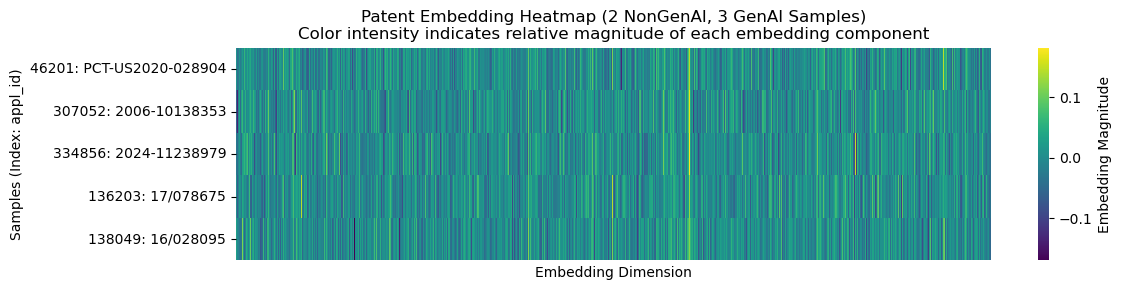

In [56]:
# Cell 6-(4a): Patent Embedding Heatmap (Binary Label Sampling)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Seed for reproducible sampling
rng = np.random.default_rng(42)

# 1) Split indices by seed_genai_label
idx0 = df_expl3.index[df_expl3["seed_genai_label"] == 0].to_numpy()  # NonGenAI
idx1 = df_expl3.index[df_expl3["seed_genai_label"] == 1].to_numpy()  # GenAI

# 2) Randomly select 2 NonGenAI and 3 GenAI samples
sel0 = rng.choice(idx0, size=2, replace=False)
sel1 = rng.choice(idx1, size=3, replace=False)
selected = np.concatenate([sel0, sel1])

# 3) Prepare embedding vectors and y‑tick labels
sample_vectors = X_all[selected]  # shape = (5, embedding_dim)
yticks_labels = [
    f"{i}: {df_expl3.loc[i, 'appl_id']}"
    for i in selected
]

# 4) Draw heatmap
plt.figure(figsize=(12, 3))
ax = sns.heatmap(
    sample_vectors,
    cmap="viridis",
    cbar=True,
    cbar_kws={'label': 'Embedding Magnitude'},
    xticklabels=False,
    yticklabels=yticks_labels
)
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Samples (Index: appl_id)")
ax.set_title(
    "Patent Embedding Heatmap (2 NonGenAI, 3 GenAI Samples)\n"
    "Color intensity indicates relative magnitude of each embedding component"
)
plt.tight_layout()
plt.show()


## **6-(4b) Vector embedding with cosine similarity**

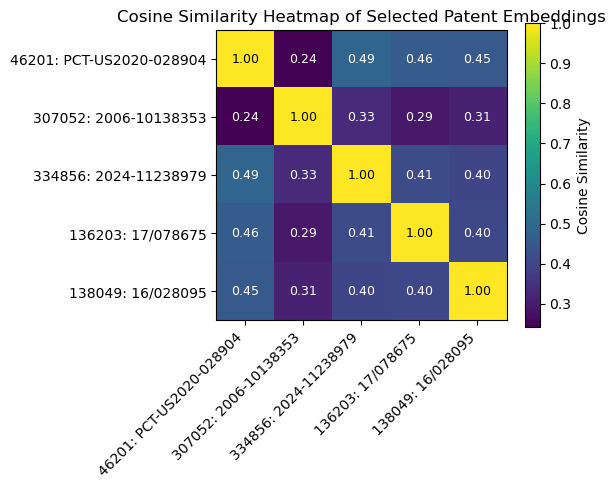

In [57]:
# Cell 6-(4b): Selected Patent Embedding Cosine Similarity Heatmap

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Assumptions:
# - X_all: full embedding array (shape = [N, dim])
# - selected: list of indices chosen for visualization (e.g., [10, 25, 37, 42, 58])

# 1) Extract the selected sample vectors
sample_vectors = X_all[selected]

# 2) Compute the cosine similarity matrix
sim_matrix = cosine_similarity(sample_vectors)

# 3) Build labels in the form "index: appl_id"
labels = [
    f"{int(idx)}: {df_expl3.loc[idx, 'appl_id']}"
    for idx in selected
]

# 4) Plot heatmap using matplotlib
fig, ax = plt.subplots(figsize=(6, 5))
cmap = plt.get_cmap('viridis')
cax = ax.imshow(sim_matrix, interpolation='nearest', aspect='equal', cmap=cmap)
fig.colorbar(cax, ax=ax, label='Cosine Similarity')

# Set tick positions and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels, rotation=0)
ax.set_title("Cosine Similarity Heatmap of Selected Patent Embeddings")

# 5) Annotate each cell with its similarity value, choosing text color based on background luminance
for i in range(sim_matrix.shape[0]):
    for j in range(sim_matrix.shape[1]):
        val = sim_matrix[i, j]
        rgba = cmap(val)
        luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        text_color = "white" if luminance < 0.5 else "black"
        ax.text(
            j, i,
            f"{val:.2f}",
            ha="center", va="center",
            fontsize=9,
            color=text_color
        )

plt.tight_layout()
plt.show()


## **6-(5) Generate a new data to hold predictions (df_pred)**

In [58]:
# Cell 6-(5): 예측 결과 저장용 데이터프레임 생성
df_pred = df_expl3.copy()  # ── 원본 df_expl3를 복사하여 예측 결과를 저장할 df_pred 생성


## **6-(6a): Ensemble Learning and Prediction (0.5 x Logistic + 0.5 x MLP)**

In [59]:
# Cell 6-(6): Ensemble Learning and Prediction

# 1) 로지스틱 회귀로부터 이진 GenAI 확률 예측
log_proba_all = log_clf.predict_proba(X_all)[:, 1]  # ── P(GenAI) 확률

# 2) MLP와 앙상블: MLP가 정의된 경우 로지스틱과 50:50 가중 평균
if mlp is not None:
    # MLP 로짓 계산 후 소프트맥스로 확률 벡터 획득
    mlp_logits_all = mlp(
        torch.tensor(X_all, dtype=torch.float32, device=DEVICE)
    )
    mlp_prob_all = torch.softmax(mlp_logits_all, dim=1)[:, 1] \
                       .detach().cpu().numpy()  # ── GenAI 클래스 확률
    # 로지스틱과 MLP 확률 앙상블
    genai_proba = 0.5 * log_proba_all + 0.5 * mlp_prob_all
    print("Using ensemble of Logistic + MLP")  # ── 앙상블 사용 알림
else:
    genai_proba = log_proba_all  # ── MLP 없으면 로지스틱만 사용
    print("Using Logistic only")  # ── 로지스틱만 사용 알림


Using ensemble of Logistic + MLP


## **6-(6b) Adjust optimal threshold (0.5 -> 0.41)**

In [101]:
# Cell 6-(6a): GenAI Binary Prediction with Adjusted Threshold at 0.36

# 3a) Raw GenAI confidence
df_pred["genai_confidence_raw"] = genai_proba  # ── 예측 확률을 df_pred에 저장

# 3b) Binary GenAI prediction
# ── 임계값 0.36 적용 (기존 0.5에서 조정)
df_pred["genai_pred"] = np.where(
    genai_proba >= 0.41,  
    "GenAI",
    "NonGenAI"
)

# 4) (Optional) 6‑way subtype prediction from multiclass logistic regression
try:
    subtype_pred_codes = multi_clf.predict(X_all)  # ── 전체 데이터에 대해 서브타입 예측
    subtype_categories  = train_type["seed_genai_type_label"].cat.categories
    df_pred["genai_subtype_pred"] = subtype_categories[subtype_pred_codes]
except NameError:
    df_pred["genai_subtype_pred"] = np.nan  # ── multi_clf가 없으면 NaN으로 채움


## **6-(3c): GenAI Prediction Distribution and Performance Evaluation**

In [102]:
# df_pred 기본/변수별 기술통계 확인
df_pred["genai_pred"].value_counts()                              # 행·열 개수 확인

genai_pred
NonGenAI    269866
GenAI       124786
Name: count, dtype: int64

In [103]:
# df_expl3 기본/변수별 기술통계 
df_expl3["seed_genai_label"].value_counts()                              # 행·열 개수 확인

seed_genai_label
0    243661
1    150991
Name: count, dtype: int64

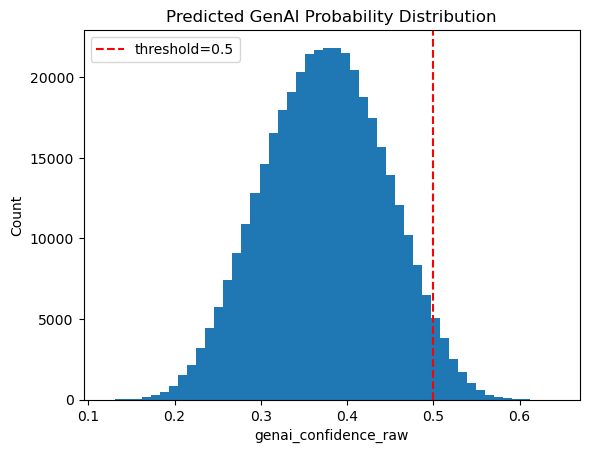

Confusion Matrix:
 [[236339   7322]
 [144598   6393]]

Classification Report:
               precision    recall  f1-score   support

    NonGenAI       0.62      0.97      0.76    243661
       GenAI       0.47      0.04      0.08    150991

    accuracy                           0.62    394652
   macro avg       0.54      0.51      0.42    394652
weighted avg       0.56      0.62      0.50    394652

True GenAI 중 올바르게 예측한 수: 6393 / 150991 (4.2%)


In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1) 예측 확률 분포 확인
plt.hist(df_pred['genai_confidence_raw'], bins=50)
plt.axvline(0.5, color='red', linestyle='--', label='threshold=0.5')
plt.title("Predicted GenAI Probability Distribution")
plt.xlabel("genai_confidence_raw")
plt.ylabel("Count")
plt.legend()
plt.show()

# 2) 혼동 행렬 및 리포트
y_true  = df_pred['seed_genai_label']
y_pred  = (df_pred['genai_confidence_raw'] >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=['NonGenAI','GenAI']))

# 3) 실제 GenAI 중 모델이 맞춘 비율
matched = df_pred[(df_pred['seed_genai_label']==1) & (y_pred==1)]
print("True GenAI 중 올바르게 예측한 수:", len(matched),
      "/", sum(y_true==1),
      f"({len(matched)/sum(y_true==1):.1%})")


## **6-(3d): Precision‑Recall Based Threshold Optimization and Classification Report**

In [105]:
# Cell 6-(3d): Precision‑Recall Based Threshold Optimization and Classification Report

from sklearn.metrics import precision_recall_curve, f1_score

# 1) Precision‑Recall curve & F1 score 계산
y_true  = df_pred['seed_genai_label']
y_score = df_pred['genai_confidence_raw']

prec, rec, thresh = precision_recall_curve(y_true, y_score)
f1   = 2 * prec * rec / (prec + rec + 1e-8)
T_opt = thresh[f1.argmax()]

print(f"Optimal threshold: {T_opt:.3f}, F1: {f1.max():.3f}")

# 2) 최적 임계값 적용 후 분류 성능 평가
y_pred_opt = (y_score >= T_opt).astype(int)
print("새 임계값 적용 시 분류 리포트:")
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_opt, target_names=['NonGenAI','GenAI']))


Optimal threshold: 0.213, F1: 0.554
새 임계값 적용 시 분류 리포트:
              precision    recall  f1-score   support

    NonGenAI       0.77      0.01      0.02    243661
       GenAI       0.38      1.00      0.55    150991

    accuracy                           0.39    394652
   macro avg       0.58      0.50      0.29    394652
weighted avg       0.62      0.39      0.22    394652



## **6-(3e): Visualization of Precision–Recall Curve and F1 Score vs Threshold**

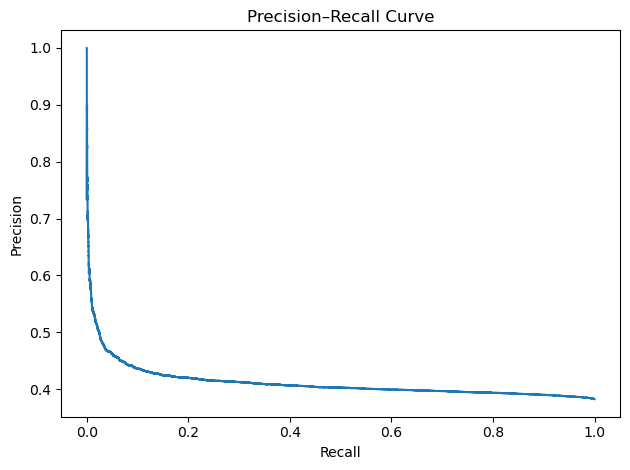

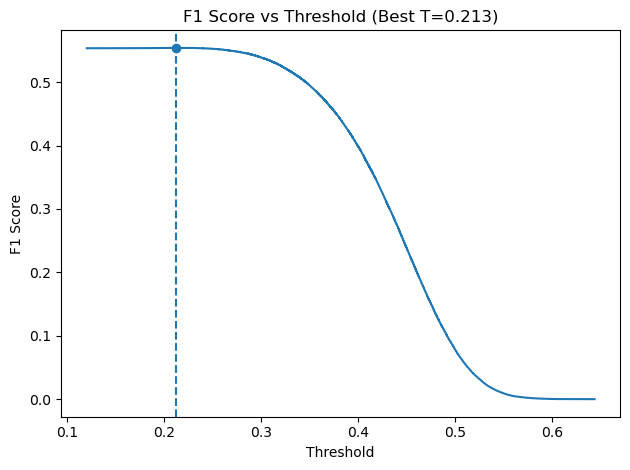

In [106]:
# Cell 6-(3e): Visualization of Precision–Recall Curve and F1 Score vs Threshold

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 1) 실제 라벨 & 예측 확률
y_true  = df_pred['seed_genai_label']
y_score = df_pred['genai_confidence_raw']

# 2) precision, recall, thresholds 계산
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# 3) thresholds에 대응하는 F1 score 계산 (마지막 포인트 제외)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)

# 4) 최적 임계값 찾기
best_idx       = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1        = f1_scores[best_idx]

# ──────────── 그래프 1: Precision-Recall Curve ────────────
plt.figure()
plt.plot(recall, precision)
plt.title('Precision–Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()

# ──────────── 그래프 2: F1 Score vs Threshold ────────────
plt.figure()
plt.plot(thresholds, f1_scores)
plt.scatter([best_threshold], [best_f1])
plt.axvline(best_threshold, linestyle='--')
plt.title(f'F1 Score vs Threshold (Best T={best_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()


In [107]:
# Preview of GenAI‑Predicted Patents
df_pred.loc[df_pred['genai_pred'] == 'GenAI', ['appl_id', 'year', 'country_code', 'seed_genai_label', 'genai_pred', 'seed_genai_type_label', 'genai_subtype_pred', 'inventor', 'inventor_nat', 'applicant', 'applicant_nat' ]].head()

appl_id    year country_code  seed_genai_label genai_pred  \
1           16/674522  2019.0           US                 1      GenAI   
2   PCT-IB2020-057160  2020.0           ZA                 1      GenAI   
4           17/039133  2020.0           US                 1      GenAI   
8           16/887692  2020.0           US                 1      GenAI   
11  PCT-IB2021-057203  2021.0           MU                 0      GenAI   

   seed_genai_type_label genai_subtype_pred                       inventor  \
1                  OTHER              OTHER  DARLINGTON SHINGIRIRAI MAPIYE   
2                    LLM              OTHER    BERRINGTON LAUREN CATHERINE   
4                  OTHER              OTHER         ISMAIL YUNUS AKHALWAYA   
8                  OTHER              OTHER             MALETSABISA MOLAPO   
11              NonGenAI                LLM                  NEL EMLI-MARI   

   inventor_nat                             applicant applicant_nat  
1            ZA                                   IBM            US  
2            ZA   BIDVEST ADVISORY SERVICES (PTY) LTD            ZA  
4            ZA                                   IBM            US  
8            ZA                                   IBM            US  
11           ZA  ADVENCO HOLDINGS PROPRIETARY LIMITED            MU

In [108]:
# Count of Unique GenAI‑Predicted Patent Records
df_pred.loc[df_pred['genai_pred'] == 'GenAI', ['appl_id', 'year', 'country_code', 'seed_genai_label', 'genai_pred', 'seed_genai_type_label', 'genai_subtype_pred', 'inventor', 'inventor_nat', 'applicant', 'applicant_nat' ]].value_counts()

appl_id            year    country_code  seed_genai_label  genai_pred  seed_genai_type_label  genai_subtype_pred  inventor                   inventor_nat  applicant                                               applicant_nat
UD2002-000103      2002.0  IT            0                 GenAI       NonGenAI               OTHER               TECCHIOLLI GIAMPIETRO      IT            NEURICAM SPA                                            IT               1
00076/DEL/2009     2009.0                0                 GenAI       NonGenAI               LLM                 LIDSTROM MATTIAS                         ERICSSON TELEFON AB L M                                                  1
PCT-US2024-062234  2024.0  US            0                 GenAI       NonGenAI               OTHER               WANG QIFEI                 US            GOOGLE INC                                              US               1
PCT-US2024-062142  2024.0  US            0                 GenAI       NonGenAI      

In [109]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = df_pred["seed_genai_type_label"]
y_pred = df_pred["genai_subtype_pred"]

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred))


Confusion Matrix:
 [[     0      0      0     26      0    735      0]
 [     0      0      0     13      0    519      0]
 [     0      0      0    296      0   4181      0]
 [     0      0      0  14554      0  19420      0]
 [     0      0      0  47265      0 196396      0]
 [     0      0      0   7164      0 103776      0]
 [     0      0      0     20      0    287      0]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

          AR       0.00      0.00      0.00       761
        DIFF       0.00      0.00      0.00       532
         GAN       0.00      0.00      0.00      4477
         LLM       0.21      0.43      0.28     33974
    NonGenAI       0.00      0.00      0.00    243661
       OTHER       0.32      0.94      0.48    110940
         VAE       0.00      0.00      0.00       307

    accuracy                           0.30    394652
   macro avg       0.08      0.19      0.11    394652
weighted avg       0.11      0.30      0.16    394652



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **7. t‑SNE Projection**

## **7-(1a) t‑SNE Projection & GenAI Binary Plot**

t‑SNE Pipeline:   0%|          | 0/4 [00:00<?, ?step/s]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] fitting GenAI view…
[t-SNE] done in 4576.3s


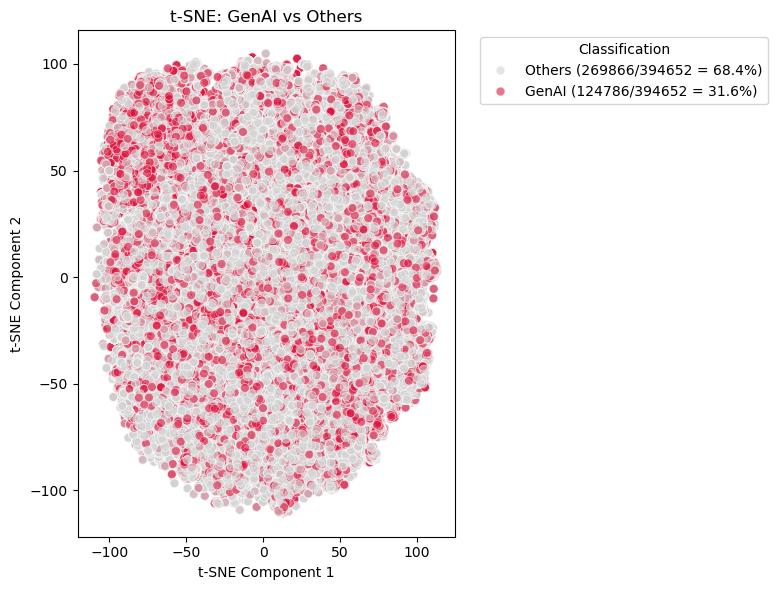

In [110]:
# Cell 7-(1a): t‑SNE Projection & GenAI Binary Plot with tqdm Pipeline
# Prepare a simple pipeline of steps
steps = ["Compute t-SNE", "Prepare DataFrame", "Compute Summary", "Plot Scatter"]

# Container for results
X_tsne = None
vis_df  = None

for step in tqdm(steps, desc="t‑SNE Pipeline", unit="step"):
    if step == "Compute t-SNE":
        print("[t-SNE] fitting GenAI view…")
        t0 = time.time()
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            n_iter=1000,
            init='random',
            random_state=42
        )
        X_tsne = tsne.fit_transform(X_all)
        print(f"[t-SNE] done in {time.time() - t0:.1f}s")

    elif step == "Prepare DataFrame":
        vis_df = pd.DataFrame({
            "tSNE1": X_tsne[:, 0],
            "tSNE2": X_tsne[:, 1],
            "GenAI": df_pred["genai_pred"].apply(
                lambda x: "GenAI" if x == "GenAI" else "Others"
            )
        })

    elif step == "Compute Summary":
        # 클래스별 개수와 비율 계산
        counts = vis_df["GenAI"].value_counts()
        total  = len(vis_df)
        # legend에 사용할 라벨 문자열 생성
        summary_labels = {
            cls: f"{cls} ({counts[cls]}/{total} = {counts[cls]/total:.1%})"
            for cls in counts.index
        }

    elif step == "Plot Scatter":
        plt.figure(figsize=(8, 6))
        ax = sns.scatterplot(
            data=vis_df,
            x="tSNE1", y="tSNE2",
            hue="GenAI",
            palette={"Others": "lightgray", "GenAI": "crimson"},
            alpha=0.6,
            s=40,
            edgecolor="white"
        )
        plt.title("t‑SNE: GenAI vs Others")
        plt.xlabel("t‑SNE Component 1")
        plt.ylabel("t‑SNE Component 2")

        # 기존 핸들/라벨을 가져와서 새 라벨로 교체
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [summary_labels.get(lab, lab) for lab in labels]
        ax.legend(handles=handles, labels=new_labels,
                  title="Classification", bbox_to_anchor=(1.05, 1), loc="upper left")

        plt.tight_layout()
        plt.show()


## **7-(1b) t‑SNE Subtype Plot (continue from Cell 14-(1a))**

In [111]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394652 entries, 0 to 394651
Data columns (total 57 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   PTO_id                 394652 non-null  object        
 1   PTO_type               394652 non-null  object        
 2   patent_kind            394652 non-null  object        
 3   pub_type_code          393037 non-null  object        
 4   title                  394643 non-null  object        
 5   title_en               360986 non-null  object        
 6   abstract               394207 non-null  object        
 7   abstract_en            360650 non-null  object        
 8   claim_main             391035 non-null  object        
 9   claim_main_en          357484 non-null  object        
 10  claims_indep           320126 non-null  object        
 11  claims_indep_en        297681 non-null  object        
 12  num_claims             329022 non-null  floa

In [112]:
df_pred["genai_subtype_pred"].value_counts()

genai_subtype_pred
OTHER    325314
LLM       69338
Name: count, dtype: int64

In [113]:
df_pred["seed_genai_type_label"].value_counts()

seed_genai_type_label
NonGenAI    243661
OTHER       110940
LLM          33974
GAN           4477
AR             761
DIFF           532
VAE            307
Name: count, dtype: int64

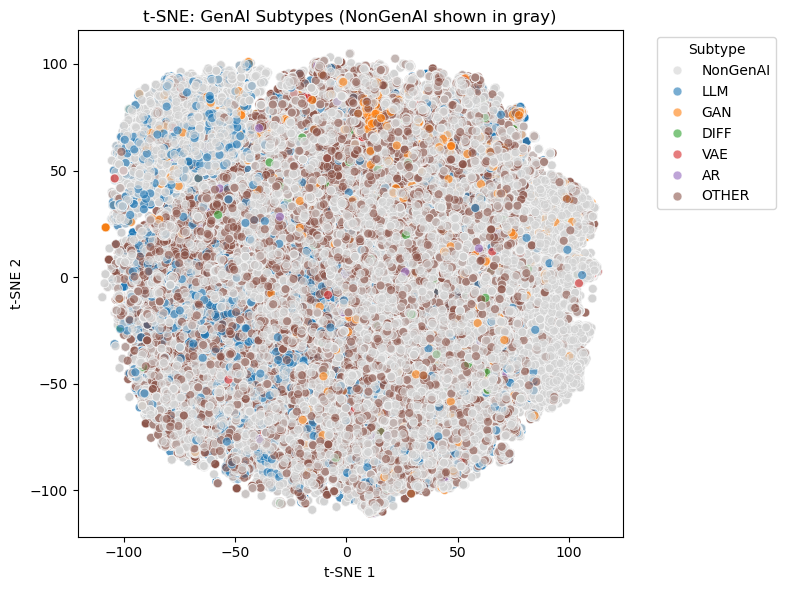

In [114]:
# Cell 7-(1b): t‑SNE Subtype Plot (continue from Cell 12-(10a))

# 1) Ensure X_tsne has been computed in previous cell
#    X_tsne = TSNE(...).fit_transform(X_all)

# 2) Extend vis_df with subtype labels and drop rows where Subtype is NA
vis_df["Subtype"] = df_pred["seed_genai_type_label"] # df_expl3 -> df_pred
plot_df = vis_df.dropna(subset=["Subtype"]).copy()

# 3) Define subtype order and palette (NonGenAI → gray)
subtypes = ["NonGenAI", "LLM", "GAN", "DIFF", "VAE", "AR", "OTHER"]
colors = sns.color_palette("tab10", n_colors=6)  # for the 6 GenAI subtypes
palette_map = {
    "NonGenAI": "lightgray",
    "LLM":      colors[0],
    "GAN":      colors[1],
    "DIFF":     colors[2],
    "VAE":      colors[3],
    "AR":       colors[4],
    "OTHER":    colors[5],
}

# 4) Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="tSNE1", y="tSNE2",
    hue="Subtype",
    hue_order=subtypes,
    palette=palette_map,
    alpha=0.6,
    s=40,
    edgecolor="white"
)
plt.title("t‑SNE: GenAI Subtypes (NonGenAI shown in gray)")
plt.xlabel("t‑SNE 1")
plt.ylabel("t‑SNE 2")

# 5) Legend
plt.legend(
    title="Subtype",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()


## **7-(1c): t‑SNE LLM Highlight Only (from Cell 14-(1a))**

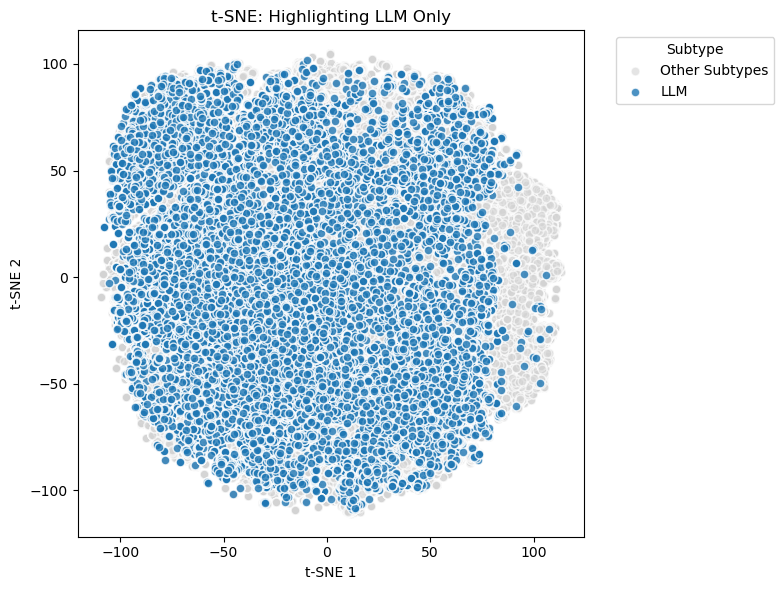

In [115]:
# Cell 7-(1c): t‑SNE LLM Highlight Only

import matplotlib.pyplot as plt

# 재사용할 LLM 색상 (palette_map에서 LLM 색상 가져오기)
llm_color = palette_map["LLM"]

# LLM가 아닌 포인트와 LLM 포인트를 마스크로 구분
mask_llm = plot_df["Subtype"] == "LLM"

plt.figure(figsize=(8, 6))

# 1) LLM이 아닌 포인트 (회색)
plt.scatter(
    plot_df.loc[~mask_llm, "tSNE1"],
    plot_df.loc[~mask_llm, "tSNE2"],
    c="lightgray",
    alpha=0.6,
    s=40,
    edgecolor="white",
    label="Other Subtypes"
)

# 2) LLM 포인트 (원래 색상)
plt.scatter(
    plot_df.loc[mask_llm, "tSNE1"],
    plot_df.loc[mask_llm, "tSNE2"],
    c=[llm_color],
    alpha=0.8,
    s=40,
    edgecolor="white",
    label="LLM"
)

plt.title("t‑SNE: Highlighting LLM Only")
plt.xlabel("t‑SNE 1")
plt.ylabel("t‑SNE 2")

# 범례
plt.legend(
    title="Subtype",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


## **7-(1d) t‑SNE LLM Highlight by Period (2000–2016 vs 2017–2023)**

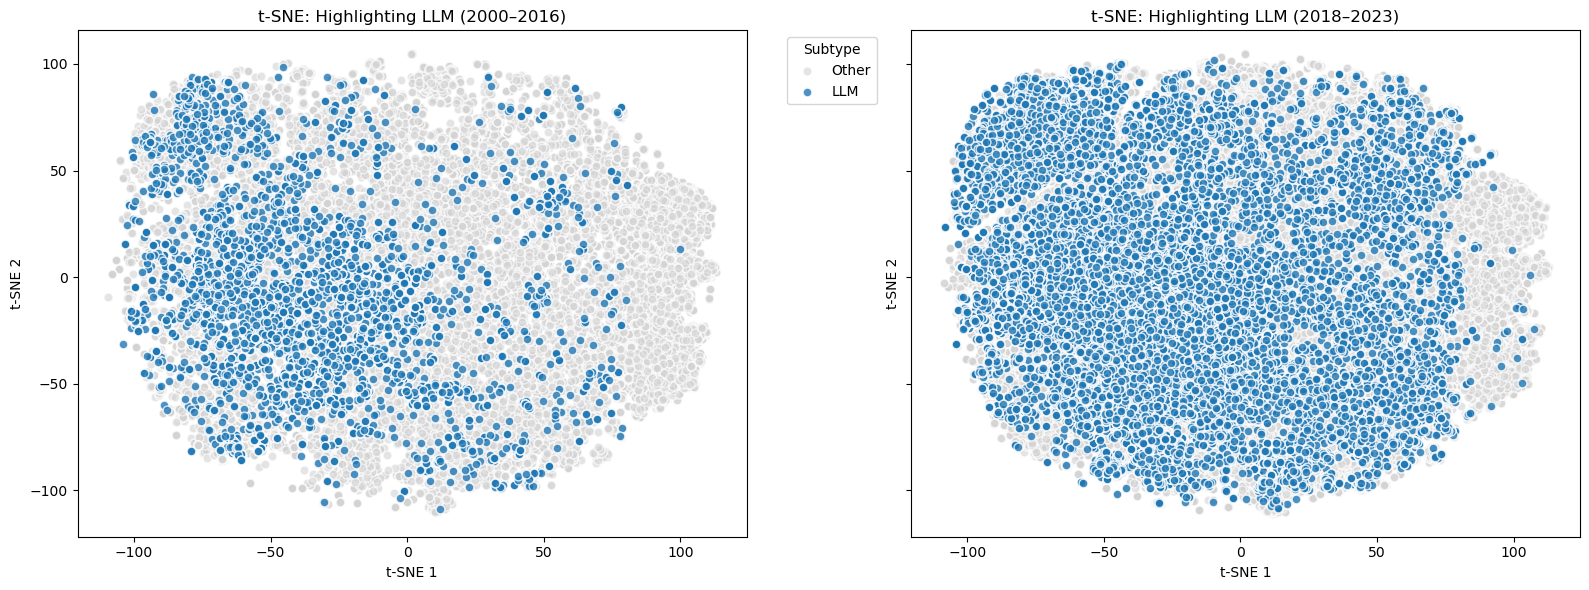

In [116]:
# Cell 7-(1d): t‑SNE LLM Highlight by Period (2000–2016 vs 2017–2023) — Legend Guard

# plot_df에 연도 정보를 추가
plot_df["year"] = df_pred["year"].values  # df_expl3 -> df_pred

# LLM 색상
llm_color = palette_map["LLM"]

# 두 개의 패널 생성
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# 비교할 기간과 제목
periods = [(2000, 2016), (2018, 2023)]
titles  = ['2000–2016', '2018–2023']

for ax, (start, end), title in zip(axes, periods, titles):
    # 기간 필터링
    mask_period = (plot_df["year"] >= start) & (plot_df["year"] <= end)
    sub = plot_df[mask_period]

    # LLM 마스크
    mask_llm = sub["Subtype"] == "LLM"

    # 비‑LLM 점들 (회색)
    ax.scatter(
        sub.loc[~mask_llm, "tSNE1"],
        sub.loc[~mask_llm, "tSNE2"],
        c="lightgray",
        alpha=0.6,
        s=40,
        edgecolor="white",
        label="Other"
    )

    # LLM 점들 (강조 색상)
    ax.scatter(
        sub.loc[mask_llm, "tSNE1"],
        sub.loc[mask_llm, "tSNE2"],
        c=[llm_color],
        alpha=0.8,
        s=40,
        edgecolor="white",
        label="LLM"
    )

    # 제목 및 축 레이블
    ax.set_title(f"t‑SNE: Highlighting LLM ({title})")
    ax.set_xlabel("t‑SNE 1")
    ax.set_ylabel("t‑SNE 2")

    # 범례 처리: 첫 번째 패널에만, None 체크 포함
    if ax is axes[0]:
        ax.legend(title="Subtype", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

# 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()


## **14-(2a): t‑SNE by CPC Main 1‑digit with Ratios**

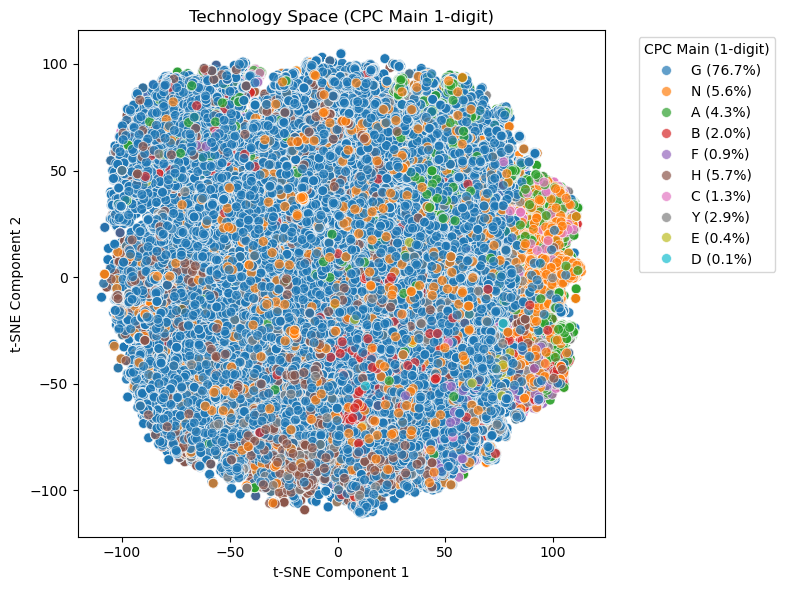

In [117]:
# Cell 7-(2a): t‑SNE by CPC Main 1‑digit with Ratios

# 0) X_tsne는 Cell 12-(10a)에서 이미 계산되어 있어야 합니다
#    (TSNE on full X_all, assigned to X_tsne)

# 1) Ensure cpc_main_norm exists and extract first character
df_expl3["cpc_main1"] = df_expl3["cpc_main_norm"].fillna("").str[:1]

# 2) Mask out Unknown/empty and non‑alphanumeric codes
mask1 = (
    df_expl3["cpc_main1"].str.match(r"[A-Z0-9]")
)

# 3) Build DataFrame for plotting
vis1 = pd.DataFrame({
    "tSNE1":     X_tsne[mask1.values, 0],
    "tSNE2":     X_tsne[mask1.values, 1],
    "cpc_main1": df_expl3.loc[mask1, "cpc_main1"].values
})

# 4) Compute ratios for each 1‑digit code
counts = vis1["cpc_main1"].value_counts().sort_index()
ratios = (counts / len(vis1) * 100).round(1).astype(str) + "%"

# 5) Scatter plot with ratio‑annotated legend
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=vis1,
    x="tSNE1", y="tSNE2",
    hue="cpc_main1",
    palette="tab10",
    alpha=0.7,
    s=50,
    edgecolor="white"
)

# 6) Update legend labels to include ratios
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"{lab} ({ratios.get(lab, '0.0%')})" for lab in labels]
ax.legend(
    handles, new_labels,
    title="CPC Main (1‑digit)",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

# 7) Final formatting
ax.set_title("Technology Space (CPC Main 1‑digit)")
ax.set_xlabel("t‑SNE Component 1")
ax.set_ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


## **7-(3a)-tSNE: Technology Space (LLM) — Highlight KR within LLM**

In [118]:
df_pred["genai_subtype_pred"].value_counts()

genai_subtype_pred
OTHER    325314
LLM       69338
Name: count, dtype: int64

In [119]:
df_pred["seed_genai_type_label"].value_counts()

seed_genai_type_label
NonGenAI    243661
OTHER       110940
LLM          33974
GAN           4477
AR             761
DIFF           532
VAE            307
Name: count, dtype: int64

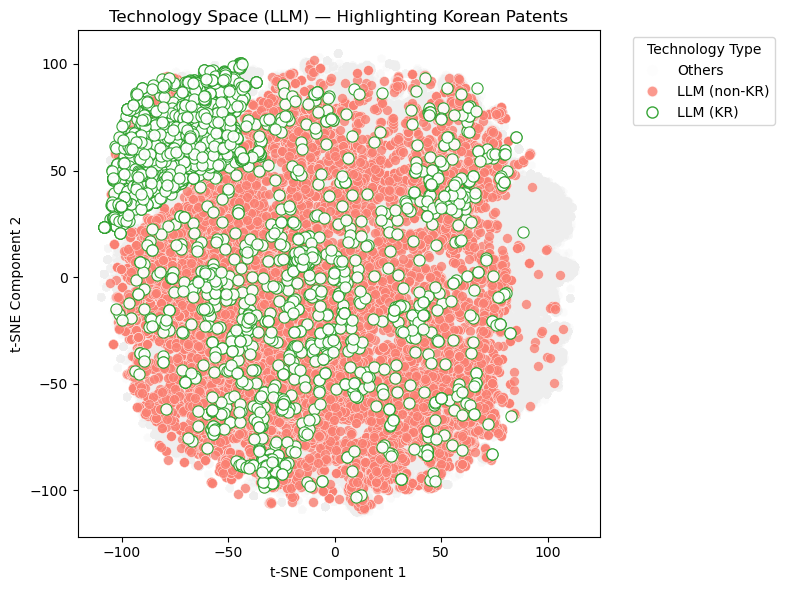

In [120]:
# Cell 7-(3a)-tSNE: Technology Space (LLM) — Highlight KR within LLM

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.manifold import TSNE

# 0) Ensure you have:
#    - X_tsne: t-SNE projections of embeddings for df_pred (or df_logistic)
#    - df_pred with columns "technology_type" and "country_code"
#    If you used df_logistic, you can swap df_pred → df_logistic below.

# 1) Assemble DataFrame for plotting
vis_df_tsne = pd.DataFrame({
    "tSNE1":           X_tsne[:, 0],
    "tSNE2":           X_tsne[:, 1],
    "technology_type": df_pred["seed_genai_type_label"].values,  # seed_genai_type_label <- genai_subtype_pred
    "country_code":    df_pred["country_code"].astype(str).values
})

# 2) Define masks
mask_llm     = vis_df_tsne["technology_type"] == "LLM"
mask_kr      = mask_llm & (vis_df_tsne["country_code"] == "KR")
mask_llm_etc = mask_llm & ~mask_kr
mask_others  = ~mask_llm  # "Others"

# 3) Plot
plt.figure(figsize=(8, 6))

# 3a) Others: very light gray
plt.scatter(
    vis_df_tsne.loc[mask_others, "tSNE1"],
    vis_df_tsne.loc[mask_others, "tSNE2"],
    color="#EEEEEE", alpha=0.07, s=35,
    edgecolors="none",
    label="Others"
)

# 3b) LLM (non‑KR): salmon
plt.scatter(
    vis_df_tsne.loc[mask_llm_etc, "tSNE1"],
    vis_df_tsne.loc[mask_llm_etc, "tSNE2"],
    color="salmon", alpha=0.8, s=50,
    edgecolors="white", linewidths=0.3,
    label="LLM (non‑KR)"
)

# 3c) LLM (KR): white fill, green edge
plt.scatter(
    vis_df_tsne.loc[mask_kr, "tSNE1"],
    vis_df_tsne.loc[mask_kr, "tSNE2"],
    facecolors="white", edgecolors="#2ca02c",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (KR)"
)

# 4) Custom legend
handles = [
    Line2D([0],[0], marker='o', linestyle='',
           markerfacecolor="#EEEEEE", markeredgecolor='none',
           alpha=0.07, markersize=8, label="Others"),
    Line2D([0],[0], marker='o', linestyle='',
           markerfacecolor="salmon", markeredgecolor='white',
           alpha=0.8, markersize=8, label="LLM (non‑KR)"),
    Line2D([0],[0], marker='o', linestyle='',
           markerfacecolor="white", markeredgecolor="#2ca02c",
           linewidth=0.8, alpha=0.95, markersize=8, label="LLM (KR)")
]
plt.legend(handles=handles, title="Technology Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")

# 5) Labels & Title
plt.title("Technology Space (LLM) — Highlighting Korean Patents")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


## **7-(3b)-tSNE: Technology Space (LLM) — Highlight KR (green) & US (blue)**

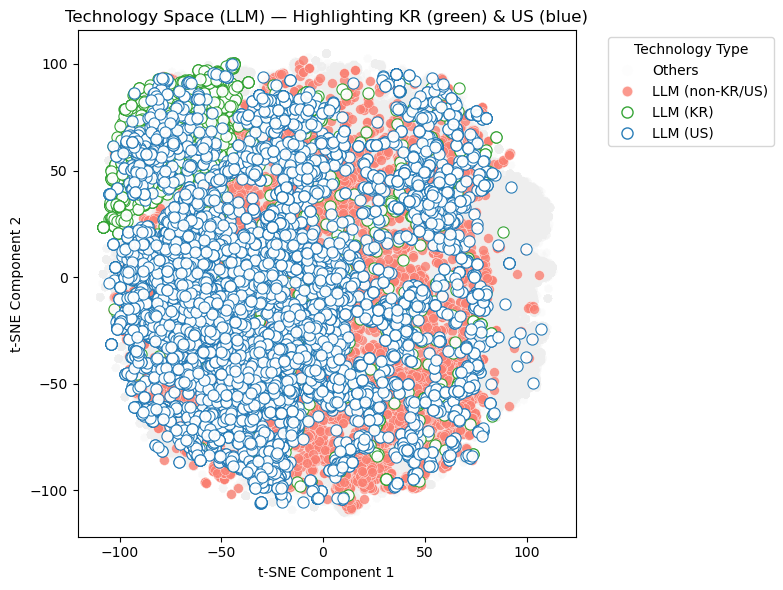

In [121]:
# Cell 7-(3b)-tSNE: Technology Space (LLM) — Highlight KR (green) & US (blue)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# 0) Ensure vis_df_tsne exists with columns: tSNE1, tSNE2, technology_type, country_code
# If not, build it from X_tsne and your prediction DataFrame (df_pred):
# vis_df_tsne = pd.DataFrame({
#     "tSNE1":           X_tsne[:, 0],
#     "tSNE2":           X_tsne[:, 1],
#     "technology_type": df_pred["genai_pred"].map({"GenAI":"LLM","NonGenAI":"Other"}).values,
#     "country_code":    df_pred["country_code"].astype(str).values
# })

# 1) Define masks
mask_llm     = vis_df_tsne["technology_type"] == "LLM"
mask_kr      = mask_llm & (vis_df_tsne["country_code"] == "KR")
mask_us      = mask_llm & (vis_df_tsne["country_code"] == "US")
mask_llm_etc = mask_llm & ~mask_kr & ~mask_us
mask_others  = ~mask_llm

# 2) Plot
plt.figure(figsize=(8, 6))

# Others: very light gray
plt.scatter(
    vis_df_tsne.loc[mask_others, "tSNE1"],
    vis_df_tsne.loc[mask_others, "tSNE2"],
    color="#EEEEEE", alpha=0.07, s=35,
    edgecolors="none",
    label="Others"
)

# LLM (non‑KR/US): salmon
plt.scatter(
    vis_df_tsne.loc[mask_llm_etc, "tSNE1"],
    vis_df_tsne.loc[mask_llm_etc, "tSNE2"],
    color="salmon", alpha=0.8, s=50,
    edgecolors="white", linewidths=0.3,
    label="LLM (non‑KR/US)"
)

# LLM (KR): white fill + green edge
plt.scatter(
    vis_df_tsne.loc[mask_kr, "tSNE1"],
    vis_df_tsne.loc[mask_kr, "tSNE2"],
    facecolors="white", edgecolors="#2ca02c",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (KR)"
)

# LLM (US): white fill + blue edge
plt.scatter(
    vis_df_tsne.loc[mask_us, "tSNE1"],
    vis_df_tsne.loc[mask_us, "tSNE2"],
    facecolors="white", edgecolors="#1f77b4",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (US)"
)

# 3) Legend
handles = [
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="#EEEEEE",
           markeredgecolor='none', alpha=0.07, markersize=8, label="Others"),
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="salmon",
           markeredgecolor='white', alpha=0.8, markersize=8, label="LLM (non‑KR/US)"),
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#2ca02c", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (KR)"),
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#1f77b4", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (US)")
]
plt.legend(handles=handles, title="Technology Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Technology Space (LLM) — Highlighting KR (green) & US (blue)")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


## **7-(3c): Technology Space (LLM) — Highlighting KR (green), US (blue), CN (red)**

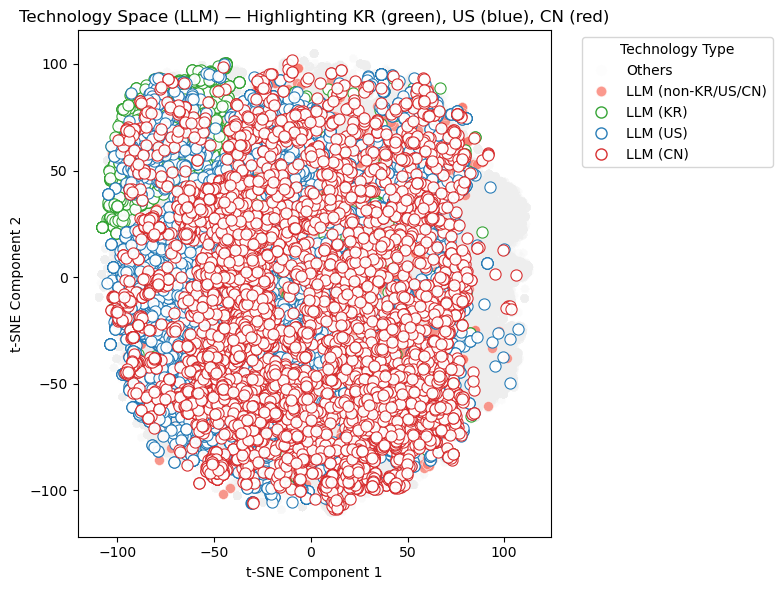

In [122]:
# Cell 7-(3c): Technology Space (LLM) — Highlighting KR (green), US (blue), CN (red)



# 0) Ensure vis_df_tsne exists with columns: tSNE1, tSNE2, technology_type, country_code
#    If your main DataFrame is df_pred, you can build it like this:
# vis_df_tsne = pd.DataFrame({
#     "tSNE1":           X_tsne[:, 0],
#     "tSNE2":           X_tsne[:, 1],
#     "technology_type": df_pred["genai_pred"].map({"GenAI": "LLM", "NonGenAI": "Others"}).values,
#     "country_code":    df_pred["country_code"].astype(str).values
# })

# 1) Define masks
mask_llm     = vis_df_tsne["technology_type"] == "LLM"
mask_kr      = mask_llm & (vis_df_tsne["country_code"] == "KR")
mask_us      = mask_llm & (vis_df_tsne["country_code"] == "US")
mask_cn      = mask_llm & (vis_df_tsne["country_code"] == "CN")
mask_llm_etc = mask_llm & ~mask_kr & ~mask_us & ~mask_cn
mask_others  = ~mask_llm

# 2) Plot
plt.figure(figsize=(8, 6))

# Others: very light gray
plt.scatter(
    vis_df_tsne.loc[mask_others, "tSNE1"],
    vis_df_tsne.loc[mask_others, "tSNE2"],
    color="#EEEEEE", alpha=0.07, s=35,
    edgecolors="none",
    label="Others"
)

# LLM (non‑KR/US/CN): salmon
plt.scatter(
    vis_df_tsne.loc[mask_llm_etc, "tSNE1"],
    vis_df_tsne.loc[mask_llm_etc, "tSNE2"],
    color="salmon", alpha=0.8, s=50,
    edgecolors="white", linewidths=0.3,
    label="LLM (non‑KR/US/CN)"
)

# LLM (KR): white fill + green edge
plt.scatter(
    vis_df_tsne.loc[mask_kr, "tSNE1"],
    vis_df_tsne.loc[mask_kr, "tSNE2"],
    facecolors="white", edgecolors="#2ca02c",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (KR)"
)

# LLM (US): white fill + blue edge
plt.scatter(
    vis_df_tsne.loc[mask_us, "tSNE1"],
    vis_df_tsne.loc[mask_us, "tSNE2"],
    facecolors="white", edgecolors="#1f77b4",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (US)"
)

# LLM (CN): white fill + red edge
plt.scatter(
    vis_df_tsne.loc[mask_cn, "tSNE1"],
    vis_df_tsne.loc[mask_cn, "tSNE2"],
    facecolors="white", edgecolors="#d62728",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (CN)"
)

# 3) Custom legend
handles = [
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="#EEEEEE",
           markeredgecolor='none', alpha=0.07, markersize=8, label="Others"),
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="salmon",
           markeredgecolor='white', alpha=0.8, markersize=8, label="LLM (non‑KR/US/CN)"),
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#2ca02c", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (KR)"),
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#1f77b4", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (US)"),
    Line2D([0], [0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#d62728", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (CN)")
]
plt.legend(handles=handles, title="Technology Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")

# 4) Labels & Title
plt.title("Technology Space (LLM) — Highlighting KR (green), US (blue), CN (red)")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


## **7-(3d1): Prepare embeddings and t‑SNE coordinates**

In [123]:
df_pred["genai_subtype_pred"].value_counts()

genai_subtype_pred
OTHER    325314
LLM       69338
Name: count, dtype: int64

In [124]:
df_pred["seed_genai_type_label"].value_counts()

seed_genai_type_label
NonGenAI    243661
OTHER       110940
LLM          33974
GAN           4477
AR             761
DIFF           532
VAE            307
Name: count, dtype: int64

In [125]:
# Cell 7-(3d1): Prepare embeddings and t‑SNE coordinates
# 1) Assemble DataFrame for plotting
vis_df_tsne = pd.DataFrame({
    "tSNE1":           X_tsne[:, 0],
    "tSNE2":           X_tsne[:, 1],
    "technology_type": df_pred["seed_genai_type_label"].values, # seed_genai_type_label <- genai_subtype_pred
    "country_code":    df_pred["country_code"].astype(str).values,
    "year":            df_pred["year"].values              # if you have a 'year' column
    })
print("Prerequisites ready: vis_df_tsne shape =", vis_df_tsne.shape)

Prerequisites ready: vis_df_tsne shape = (394652, 5)


## **7-(3d2): t‑SNE by 5‑Year Periods**

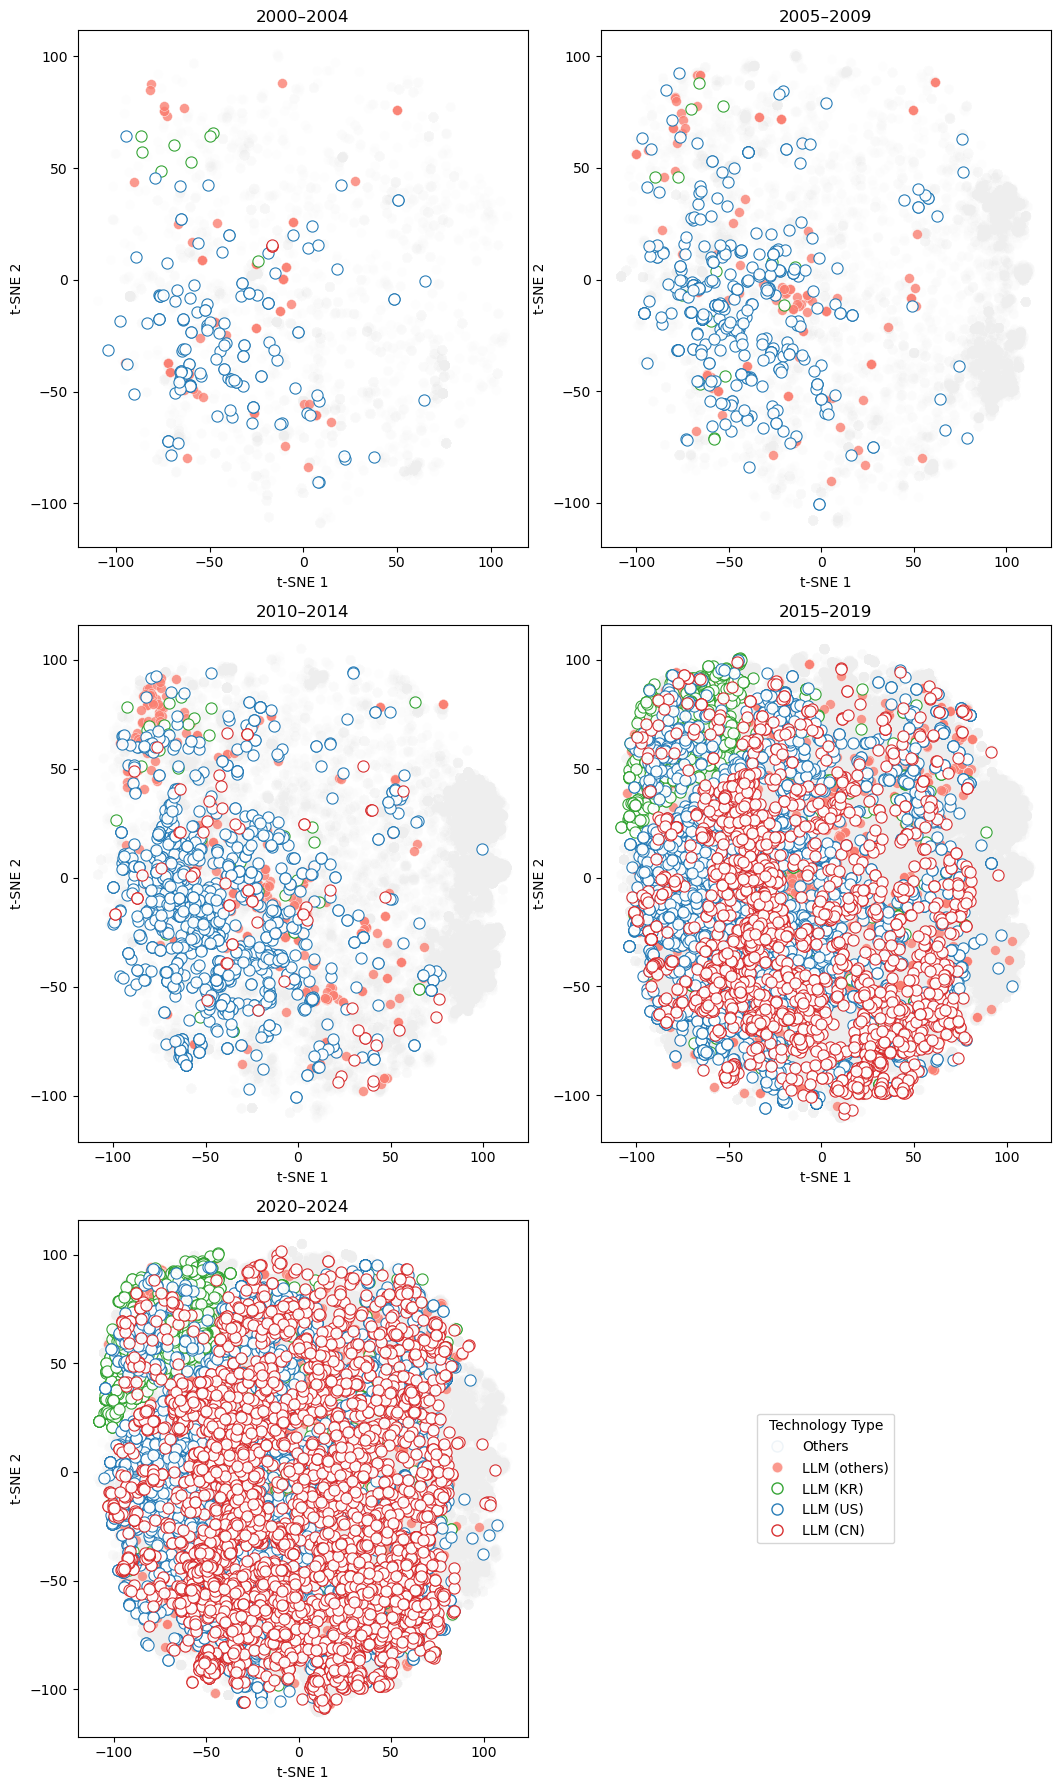

In [126]:
# Cell 7-(3d2): t‑SNE by 5‑Year Periods
# ── Ensure year is integer ──
vis_df_tsne["year"] = vis_df_tsne["year"].astype(int)

# ── Define the 5‑year bins ──
periods = [
    ("2000–2004", range(2000, 2005)),
    ("2005–2009", range(2005, 2010)),
    ("2010–2014", range(2010, 2015)),
    ("2015–2019", range(2015, 2020)),
    ("2020–2024", range(2020, 2025))
]
# ── Prepare subplots (3×2 grid, last for legend) ──
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

for i, (label, yrs) in enumerate(periods):
    ax = axes[i]
    sub = vis_df_tsne[vis_df_tsne["year"].isin(yrs)]

    # Masks
    m_llm    = sub["technology_type"] == "LLM"
    m_oth    = ~m_llm
    m_kr     = m_llm & (sub["country_code"] == "KR")
    m_us     = m_llm & (sub["country_code"] == "US")
    m_cn     = m_llm & (sub["country_code"] == "CN")
    m_etc    = m_llm & ~m_kr & ~m_us & ~m_cn

    # Plot layers
    ax.scatter(sub.loc[m_oth, "tSNE1"], sub.loc[m_oth, "tSNE2"],
               color="#EEEEEE", alpha=0.07, s=50, edgecolors="none")
    ax.scatter(sub.loc[m_etc, "tSNE1"], sub.loc[m_etc, "tSNE2"],
               color="salmon", alpha=0.8, s=50, edgecolors="white", linewidths=0.3)
    ax.scatter(sub.loc[m_kr, "tSNE1"], sub.loc[m_kr, "tSNE2"],
               facecolors="white", edgecolors="#2ca02c",
               linewidths=0.8, alpha=0.95, s=65)
    ax.scatter(sub.loc[m_us, "tSNE1"], sub.loc[m_us, "tSNE2"],
               facecolors="white", edgecolors="#1f77b4",
               linewidths=0.8, alpha=0.95, s=65)
    ax.scatter(sub.loc[m_cn, "tSNE1"], sub.loc[m_cn, "tSNE2"],
               facecolors="white", edgecolors="#d62728",
               linewidths=0.8, alpha=0.95, s=65)

    ax.set_title(label)
    ax.set_xlabel("t‑SNE 1")
    ax.set_ylabel("t‑SNE 2")

# Remove empty 6th plot
fig.delaxes(axes[-1])

# ── Legend panel ──
leg_ax = fig.add_subplot(3, 2, 6)
leg_ax.axis("off")
handles = [
    Line2D([0],[0], marker="o", linestyle="", markerfacecolor="#EEEEEE", alpha=0.07, markersize=8, label="Others"),
    Line2D([0],[0], marker="o", linestyle="", markerfacecolor="salmon", markeredgecolor="white", alpha=0.8, markersize=8, label="LLM (others)"),
    Line2D([0],[0], marker="o", linestyle="", markerfacecolor="white", markeredgecolor="#2ca02c", alpha=0.95, markersize=8, label="LLM (KR)"),
    Line2D([0],[0], marker="o", linestyle="", markerfacecolor="white", markeredgecolor="#1f77b4", alpha=0.95, markersize=8, label="LLM (US)"),
    Line2D([0],[0], marker="o", linestyle="", markerfacecolor="white", markeredgecolor="#d62728", alpha=0.95, markersize=8, label="LLM (CN)")
]
leg_ax.legend(handles=handles, title="Technology Type", loc="center")

plt.tight_layout()
plt.subplots_adjust(right=0.88)  # make space for legend panel
plt.show()

# **8. Network Analysis**

## **8-(1) Initialize Network DataFrame and Analysis Period (df_network)**

In [183]:
# Cell 8-(1): Initialize Network DataFrame and Analysis Period

# 1) Copy the source DataFrame for network construction
df_network = df_expl.copy()

# 2) Define analysis period
year_sel = list(range(2000, 2024)) # 2000 - 2023

## **8-(2): Filter Network for LLM Patents**

In [184]:
# Cell 8-(2): Filter to LLM Patents

# 1) Get the list of appl_ids predicted as LLM (from your df_pred)
llm_appl_ids = df_pred.loc[
    df_pred["genai_pred"] == "GenAI",
    "appl_id"
].unique().tolist()

# 2) Keep only inventor–patent rows for those LLM appl_ids
df_network_llm = df_network[df_network["appl_id"].isin(llm_appl_ids)].copy()
print(f"Raw inventor–patent rows for LLM: {df_network_llm.shape[0]}")


Raw inventor–patent rows for LLM: 539457


## **8-(3) Co‑Authorship Network and Edge Weights**

In [185]:
# # Cell 8-(3): Build Co‑Inventor Graph


# # 1) Aggregate all inventors per appl_id (within your year range)
# inventors_per_patent = (
#     df_network_llm[df_network_llm["year"].isin(year_sel)]
#     .groupby("appl_id")["inventor"]      # or 'inventor_pre' if that’s your column
#     .agg(lambda ids: ids.dropna().unique().tolist())
# )

# # 2) Build graph by creating an edge for every inventor pair on each patent
# G_llm = nx.Graph()
# for inv_list in inventors_per_patent:
#     for a, b in combinations(inv_list, 2):
#         if G_llm.has_edge(a, b):
#             G_llm[a][b]["weight"] += 1
#         else:
#             G_llm.add_edge(a, b, weight=1)

# # 3) Extract top 1000 inventors by degree weight
# top_nodes = sorted(
#     G_llm.degree(weight="weight"),
#     key=lambda x: x[1],
#     reverse=True
# )[:1000]
# G_sub = G_llm.subgraph([n for n, w in top_nodes]).copy()

# # 4) Summary
# print(f"▶︎ LLM co‑authorship subgraph: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")


▶︎ LLM co‑authorship subgraph: 1000 nodes, 12662 edges


## **8-(4) Periodized Co‑Authorship Networks (Top 1000 nodes)**

In [186]:
# # Cell 8-(4): Periodized Co‑Authorship Networks (Top 1000 nodes)
# # 1) Top 1000 nodes by weighted degree
# deg_full = dict(G_llm.degree(weight='weight'))
# top1000   = sorted(deg_full, key=deg_full.get, reverse=True)[:1000]
# G        = G_llm.subgraph(top1000).copy()

# # 2) Define 5‑year bins
# periods = [
#     ("2000–2004", range(2000, 2005)),
#     ("2005–2009", range(2005, 2010)),
#     ("2010–2014", range(2010, 2015)),
#     ("2015–2019", range(2015, 2020)),
#     ("2020–2024", range(2020, 2025)),
# ]

# # 3) Fixed layout
# pos = nx.spring_layout(G, k=0.2, iterations=30, seed=42)

# # 4) Country grouping & colors
# def group_country(code):
#     return code if code in {"KR","US","CN"} else "Others"

# nat_map     = {n: df_network_llm.loc[df_network_llm['inventor']==n,'inventor_nat'].iloc[0]
#                for n in G.nodes()}
# country_map = {n: group_country(nat_map[n]) for n in G.nodes()}
# colors      = {"Others":"#EEEEEE","KR":"#2ca02c","US":"#1f77b4","CN":"#d62728"}

# # 5) Node sizes & edge widths
# deg         = dict(G.degree(weight='weight'))
# node_sizes  = {n: (deg[n]+1)*0.8 for n in G.nodes()}
# edges       = [(u,v,d['weight']) for u,v,d in G.edges(data=True)]
# max_w       = max(w for *_,w in edges) if edges else 1
# edgelist    = [(u,v) for u,v,_ in edges]
# edge_widths = [w/max_w*10 for *_,w in edges]

# # 6) Map inventor → years
# inv_years = (df_network_llm.groupby('inventor')['year']
#                          .apply(lambda s: set(s))
#                          .to_dict())

# # 7) Plot grid
# fig, axes = plt.subplots(3, 2, figsize=(14, 18))
# axes = axes.flatten()

# for i, (title, yrs) in enumerate(periods):
#     ax = axes[i]
#     active = {inv for inv, yrs_inv in inv_years.items() if yrs_inv & set(yrs)}

#     # Draw edges
#     nx.draw_networkx_edges(
#         G, pos, edgelist=edgelist,
#         width=edge_widths, edge_color='gray', alpha=0.3, ax=ax
#     )

#     # Draw nodes by country group
#     for grp in ["Others","KR","US","CN"]:
#         nodes_grp = [n for n in G.nodes() if country_map[n]==grp and n in active]
#         if grp=="Others":
#             ax.scatter(
#                 [pos[n][0] for n in nodes_grp],
#                 [pos[n][1] for n in nodes_grp],
#                 s=[node_sizes[n] for n in nodes_grp],
#                 c=colors[grp], alpha=0.07, edgecolors='none'
#             )
#         else:
#             ax.scatter(
#                 [pos[n][0] for n in nodes_grp],
#                 [pos[n][1] for n in nodes_grp],
#                 facecolors='white', edgecolors=colors[grp],
#                 s=[node_sizes[n] for n in nodes_grp],
#                 linewidths=0.8, alpha=0.95
#             )

#     ax.set_title(title, fontsize=12)
#     ax.axis('off')

# # Legend panel
# legend_ax = axes[-1]
# legend_ax.axis('off')
# handles = [
#     Line2D([0],[0], marker='o', linestyle='', markersize=8,
#            markerfacecolor=colors["Others"], markeredgecolor='none',
#            alpha=0.07, label="Others"),
#     Line2D([0],[0], marker='o', linestyle='', markersize=8,
#            markerfacecolor='white', markeredgecolor=colors["KR"],
#            linewidth=0.8, alpha=0.95, label="KR"),
#     Line2D([0],[0], marker='o', linestyle='', markersize=8,
#            markerfacecolor='white', markeredgecolor=colors["US"],
#            linewidth=0.8, alpha=0.95, label="US"),
#     Line2D([0],[0], marker='o', linestyle='', markersize=8,
#            markerfacecolor='white', markeredgecolor=colors["CN"],
#            linewidth=0.8, alpha=0.95, label="CN"),
# ]
# legend_ax.legend(handles=handles, title="Country", loc='center')

# plt.tight_layout()
# plt.subplots_adjust(right=0.88)
# plt.show()

## **8-(5): Create co‑inventor network and compute edge weights)**

In [187]:
# # Cell 8-(5): Create co‑inventor network and compute edge weights

# # 1) Extract unique inventor lists per patent from df_network_llm
# inventors_per_patent = (
#     df_network_llm[df_network_llm['year'].isin(year_sel)]
#         .groupby('appl_id')['inventor']
#         .agg(lambda x: x.unique().tolist())
# )

# # 2) Build the graph G and add edges
# G = nx.Graph()
# for inv_list in inventors_per_patent:
#     if len(inv_list) < 2:
#         continue
#     for i, a in enumerate(inv_list):
#         for b in inv_list[i+1:]:
#             if G.has_edge(a, b):
#                 G[a][b]['weight'] += 1
#             else:
#                 G.add_edge(a, b, weight=1)

# # 3) Limit to top 1000 nodes by degree
# no_nodes = 1000
# deg_dict = dict(G.degree())
# if deg_dict:
#     top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:no_nodes]
#     G = G.subgraph(top_nodes).copy()

# # 4) Summary
# print(f"Subgraph ({min(year_sel)}–{max(year_sel)}): "
#       f"nodes = {G.number_of_nodes()}, edges = {G.number_of_edges()}")

## **8-(6) Visualize co‑authorship network**

In [188]:
# # Cell 8-(6) Visualize co‑authorship network with legend sorted by descending group ratio


# # ▼ 추가: 한글을 ASCII로 변환하기 위한 라이브러리
# try:
#     from unidecode import unidecode
# except ImportError:
#     # 설치 안 되어 있으면 간단한 fallback (한글 문자 제거)
#     def unidecode(s):
#         return s.encode('ascii', 'ignore').decode()

# # 1) Prune nodes with degree < 1
# min_degree = 1
# nodes_kept = [n for n, d in G.degree() if d >= min_degree]
# G2 = G.subgraph(nodes_kept).copy()

# # 2) Layout, sizes, widths
# pos = nx.spring_layout(G2, k=0.2, iterations=20, seed=42)
# deg = dict(G2.degree())
# nodes, degrees = zip(*deg.items())
# node_sizes = [(d + 1) * 5 for d in degrees]
# weights = [G2[u][v]['weight'] for u, v in G2.edges()]
# widths = [w / max(weights) * 5 for w in weights] if weights else []

# # 3) Nationality map (from df_network_llm)
# nat_map = {
#     n: df_network_llm.loc[df_network_llm['inventor'] == n, 'inventor_nat'].iloc[0]
#     for n in nodes
# }

# # 4) Grouping: GB, EU, Others
# EU_CODES = {
#     "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
#     "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
# }
# group_map = {
#     n: (
#         'GB' if nat_map.get(n) == 'GB' else
#         'EU' if nat_map.get(n) in EU_CODES else
#         nat_map.get(n, 'UN')
#     )
#     for n in nodes
# }

# # compute counts and ratios
# total_nodes = len(nodes)
# group_counts = {g: sum(1 for n in nodes if group_map[n] == g) for g in set(group_map.values())}
# group_ratios = {g: group_counts[g] / total_nodes for g in group_counts}

# # sort groups by descending ratio
# sorted_groups = sorted(group_ratios, key=lambda g: group_ratios[g], reverse=True)

# # 5) Colormap
# cmap = mpl.colormaps['tab20']
# colors = [cmap(i / max(1, len(sorted_groups)-1)) for i in range(len(sorted_groups))]
# color_map = {g: colors[i] for i, g in enumerate(sorted_groups)}
# node_colors = [color_map[group_map[n]] for n in nodes]

# # 6) Draw edges and nodes
# plt.figure(figsize=(12, 12))
# nx.draw_networkx_edges(G2, pos, width=widths, edge_color='gray', alpha=0.5)
# nx.draw_networkx_nodes(G2, pos,
#                        nodelist=nodes,
#                        node_size=node_sizes,
#                        node_color=node_colors,
#                        alpha=0.8,
#                        linewidths=0.5,
#                        edgecolors='grey')

# # 7) Label top 10 by degree, but **ASCII 변환해서 표기**
# top10 = sorted(deg, key=deg.get, reverse=True)[:10]

# # ▼ 변경: 한글 이름을 ASCII로 변환해 라벨로 사용
# top10_labels = {n: unidecode(str(n))[:8] for n in top10}  # 길이는 적당히 자르세요(여기선 8자)

# texts = []
# for n in top10:
#     x, y = pos[n]
#     texts.append(plt.text(x, y, top10_labels[n], fontsize=8))  # ← 여기서 ASCII 라벨 사용

# adjust_text(texts,
#             expand_points=(1.1, 1.1),
#             arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# # 8) Legends
# avg_deg = int(sum(degrees) / total_nodes)
# size_handles = [
#     plt.scatter([], [], s=(d + 1) * 5, color='skyblue', alpha=0.8)
#     for d in [min(degrees), avg_deg, max(degrees)]
# ]
# size_labels = [f'degree={d}' for d in [min(degrees), avg_deg, max(degrees)]]
# removed_handle = mlines.Line2D([], [], linestyle='None', marker='x',
#                                color='black', label=f'Removed (<{min_degree})')

# # create group legend handles in sorted order
# group_handles = [
#     mpatches.Patch(
#         color=color_map[g],
#         label=f"{g}: {group_counts[g]}/{total_nodes} ({group_ratios[g]:.1%})"
#     )
#     for g in sorted_groups
# ]

# all_handles = size_handles + [removed_handle] + group_handles
# all_labels  = size_labels  + [removed_handle.get_label()] + [h.get_label() for h in group_handles]

# plt.legend(all_handles, all_labels,
#            title='Size / Removed / Country (by ratio ↓)',
#            bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.axis('off')
# plt.title(f'Co‑Authorship Network ({min(year_sel)}–{max(year_sel)})', fontsize=14)
# plt.tight_layout()
# plt.show()


## **8-(7) Build Co‑Authorship Graphs for 5‑Year Periods**

In [189]:
# # Cell 8-(7) Build Co‑Authorship Graphs for 5‑Year Periods

# # 1) Define the 5‑year bins
# periods = [
#     ("2000–2004", range(2000, 2005)),
#     ("2005–2009", range(2005, 2010)),
#     ("2010–2014", range(2010, 2015)),
#     ("2015–2019", range(2015, 2020)),
#     ("2020–2024", range(2020, 2025)),
# ]

# # 2) For each period, build and prune the subgraph
# G_periods = {}
# no_nodes = 1000

# for label, yrs in periods:
#     # 2a) Extract unique inventor lists per patent in this period
#     inv_lists = (
#         df_network_llm[df_network_llm["year"].isin(yrs)]
#             .groupby("appl_id")["inventor"]
#             .agg(lambda x: x.unique().tolist())
#     )
#     # 2b) Build graph
#     Gp = nx.Graph()
#     for invs in inv_lists:
#         if len(invs) < 2:
#             continue
#         for i, a in enumerate(invs):
#             for b in invs[i+1:]:
#                 if Gp.has_edge(a, b):
#                     Gp[a][b]["weight"] += 1
#                 else:
#                     Gp.add_edge(a, b, weight=1)
#     # 2c) Prune to top no_nodes by degree
#     degs = dict(Gp.degree())
#     top = sorted(degs, key=degs.get, reverse=True)[:no_nodes]
#     G_periods[label] = Gp.subgraph(top).copy()
#     print(f"{label}: nodes={G_periods[label].number_of_nodes()}, "
#           f"edges={G_periods[label].number_of_edges()}")


## **8-(8) Visualize Periodic Co‑Authorship Networks**

In [190]:
# # Cell 8-(8) Visualize Periodic Co‑Authorship Networks with Sorted Legend

# # 1) Ensure G_periods is defined
# if 'G_periods' not in globals():
#     raise RuntimeError("Run Cell 8-(7) first to build G_periods")

# # 2) Prepare plot grid
# fig, axes = plt.subplots(3, 2, figsize=(14, 18))
# axes = axes.flatten()

# # 3) Define country grouping and base colours
# EU_CODES = {
#     "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
#     "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
# }
# all_groups = ["US","CN","GB","KR","EU","JP","IL","IN","CH","UN"]
# cmap = plt.get_cmap("tab10", len(all_groups))
# group_color = {g: cmap(i) for i, g in enumerate(all_groups)}

# for idx, (label, Gp) in enumerate(G_periods.items()):
#     ax = axes[idx]
#     pos = nx.spring_layout(Gp, k=0.2, seed=42)
#     deg = dict(Gp.degree())
#     nodes = list(deg.keys())
#     sizes = [(deg[n] + 1) * 10 for n in nodes]

#     # Map inventor → nationality
#     nat = {
#         n: df_network_llm.loc[df_network_llm["inventor"] == n, "inventor_nat"].iloc[0]
#         for n in nodes
#     }
#     # Assign group
#     grp = {
#         n: (
#             "US" if nat[n] == "US" else
#             "CN" if nat[n] == "CN" else
#             "GB" if nat[n] == "GB" else
#             "KR" if nat[n] == "KR" else
#             "EU" if nat[n] in EU_CODES else
#             n and "UN"
#         )
#         for n in nodes
#     }
#     colors = [group_color[grp[n]] for n in nodes]

#     # Draw edges & nodes
#     nx.draw_networkx_edges(Gp, pos, ax=ax, alpha=0.3, edge_color="gray")
#     nx.draw_networkx_nodes(
#         Gp, pos, ax=ax,
#         node_size=sizes,
#         node_color=colors,
#         linewidths=0.2,
#         edgecolors="black"
#     )
#     ax.set_title(label)
#     ax.axis("off")

# # 4) Remove unused subplot
# fig.delaxes(axes[-1])

# # 5) Build legend sorted by descending ratio
# total = sum(len(Gp.nodes()) for Gp in G_periods.values())
# # Count across the last period (or combine as needed)
# last_nodes = list(G_periods[list(G_periods.keys())[-1]].nodes())
# group_counts = {g: 0 for g in all_groups}
# for n in last_nodes:
#     group_counts[grp[n]] += 1
# group_ratios = {g: group_counts[g]/len(last_nodes) for g in all_groups}
# sorted_groups = sorted(group_ratios, key=lambda g: group_ratios[g], reverse=True)

# size_handles = [
#     plt.scatter([], [], s=(d + 1) * 10, color='skyblue', alpha=0.8)
#     for d in sorted([deg[n] for n in last_nodes])[::len(last_nodes)//2 or 1]
# ]
# size_labels = [f'degree={d}' for d in sorted([deg[n] for n in last_nodes])[::len(last_nodes)//2 or 1]]
# removed_handle = mlines.Line2D([], [], linestyle='None', marker='x',
#                                color='black', label='Removed (<1)')

# handles_country = [
#     mpatches.Patch(
#         color=group_color[g],
#         label=f"{g}: {group_counts[g]}/{len(last_nodes)} ({group_ratios[g]*100:.1f}%)"
#     )
#     for g in sorted_groups if group_counts[g] > 0
# ]

# all_handles = size_handles + [removed_handle] + handles_country
# plt.legend(
#     all_handles,
#     [h.get_label() for h in all_handles],
#     title='Size / Removed / Country (by ratio ↓)',
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left'
# )

# plt.tight_layout()
# plt.show()


## **8-(9) Build Co‑Authorship Graphs for 5‑Year Periods**

In [191]:
# Cell 8-(9) Build Co‑Authorship Graphs for 5‑Year Periods

# 1) Define the 5‑year bins
periods = [
    ("2000–2004", range(2000, 2005)),
    ("2005–2009", range(2005, 2010)),
    ("2010–2014", range(2010, 2015)),
    ("2015–2019", range(2015, 2020)),
    ("2020–2024", range(2020, 2025)),
]

# 2) For each period, build and prune the subgraph
G_periods = {}
no_nodes = 1000

for label, yrs in periods:
    inv_lists = (
        df_network_llm[df_network_llm["year"].isin(yrs)]
            .groupby("appl_id")["inventor"]
            .agg(lambda x: x.unique().tolist())
    )
    Gp = nx.Graph()
    for invs in inv_lists:
        if len(invs) < 2:
            continue
        for i, a in enumerate(invs):
            for b in invs[i+1:]:
                if Gp.has_edge(a, b):
                    Gp[a][b]["weight"] += 1
                else:
                    Gp.add_edge(a, b, weight=1)
    degs = dict(Gp.degree())
    top = sorted(degs, key=degs.get, reverse=True)[:no_nodes]
    G_periods[label] = Gp.subgraph(top).copy()
    print(f"{label}: nodes={G_periods[label].number_of_nodes()}, "
          f"edges={G_periods[label].number_of_edges()}")


2000–2004: nodes=1000, edges=1975
2005–2009: nodes=1000, edges=4119
2010–2014: nodes=1000, edges=5629
2015–2019: nodes=1000, edges=9787
2020–2024: nodes=1000, edges=13152


## **8-(10) Visualize Periodic Co‑Authorship Networks**

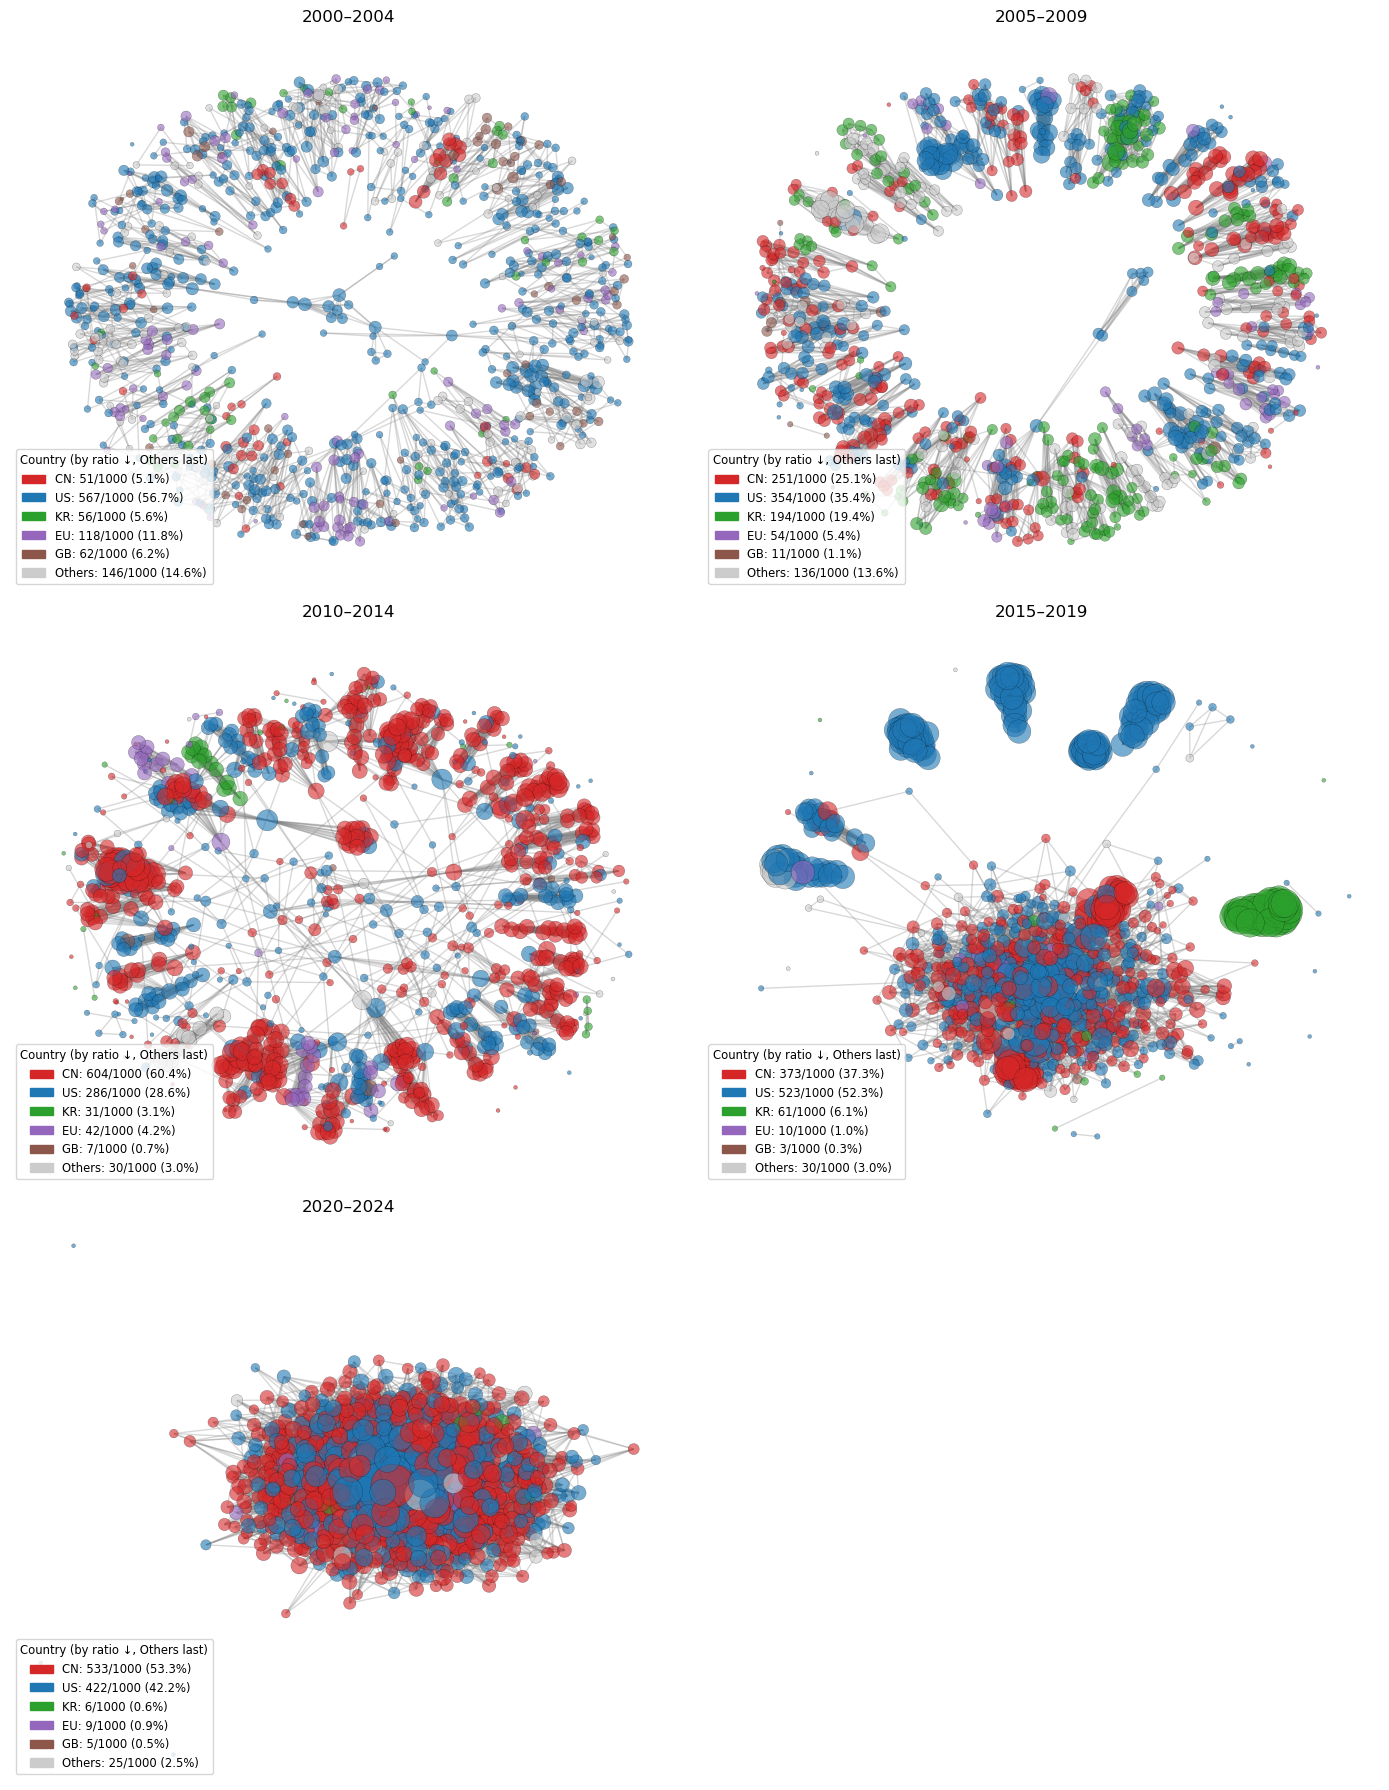

In [192]:
# Cell 8-(10) Visualize Periodic Co‑Authorship Networks with Consistent Country Colors & Transparency

# Ensure G_periods is available
if 'G_periods' not in globals():
    raise RuntimeError("Run Cell 13-(3) first")

# Country grouping setup and explicit colors
EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
# fixed colors
group_color = {
    "CN": "#d62728",    # red
    "US": "#1f77b4",    # blue
    "KR": "#2ca02c",    # green
    "EU": "#9467bd",    # purple
    "GB": "#8c564b",    # brown
    "Others": "#CCCCCC" # grey
}
all_groups = list(group_color.keys())

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for idx, (label, Gp) in enumerate(G_periods.items()):
    ax = axes[idx]
    pos = nx.spring_layout(Gp, k=0.2, seed=42)
    deg = dict(Gp.degree())
    nodes = list(deg.keys())
    sizes = [(deg[n] + 1) * 8 for n in nodes]

    # Map inventor → nationality group
    nat = {
        n: df_network_llm.loc[df_network_llm["inventor"] == n, "inventor_nat"].iloc[0]
        for n in nodes
    }
    grp = {
        n: (
            "CN" if nat[n] == "CN" else
            "US" if nat[n] == "US" else
            "KR" if nat[n] == "KR" else
            "EU" if nat[n] in EU_CODES else
            "GB" if nat[n] == "GB" else
            "Others"
        )
        for n in nodes
    }
    colors = [group_color[grp[n]] for n in nodes]

    # Draw edges & nodes with transparency
    nx.draw_networkx_edges(Gp, pos, ax=ax, alpha=0.3, edge_color="gray")
    nx.draw_networkx_nodes(
        Gp, pos, ax=ax,
        node_size=sizes,
        node_color=colors,
        alpha=0.6,              # uniform transparency
        linewidths=0.2,
        edgecolors="black"
    )

    ax.set_title(label)
    ax.axis("off")

    # Build legend for this subplot, Others last
    counts = {g: sum(1 for n in nodes if grp[n] == g) for g in all_groups}
    total = len(nodes)
    sorted_groups = [g for g in ["CN","US","KR","EU","GB"] if counts[g]>0] + ["Others"]
    handles = []
    for g in sorted_groups:
        if counts[g] == 0:
            continue
        pct = counts[g] / total * 100
        handles.append(mpatches.Patch(
            color=group_color[g],
            label=f"{g}: {counts[g]}/{total} ({pct:.1f}%)"
        ))

    ax.legend(
        handles=handles,
        title="Country (by ratio ↓, Others last)",
        loc="lower left",
        fontsize='small',
        title_fontsize='small'
    )

# Remove unused subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


# **9. Core-Periphery Analysis**

### Spectral Core–Periphery Detection

In this p we approximate a discrete core–periphery blockmodel by using the leading eigenvector of the adjacency matrix.

1. Given a graph $G$ with adjacency matrix $A$, compute the eigenpairs $(\lambda_i, v_i)$ of $A$.  
2. Take the principal eigenvector $(v_{\max})$ corresponding to the largest eigenvalue $(\lambda_{\max})$.  
3. The absolute entries $(\lvert v_{\max,i}\rvert)$ serve as a continuous “coreness” score for node \(i\).  
4. By thresholding these scores (e.g. at their median), we assign each node to **Core** (high score) or **Periphery** (low score).

This spectral method often recovers a similar core–periphery partition to Borgatti–Everett blockmodeling, but requires no external package.
Display example equation: $$A\,v = \lambda\,v$$

## **9-(1a) Calculate KR Core/Periphery via spectral blockmodeling**

In [204]:
# # Cell 9-(1a): Calculate Core/Periphery for US, CN, KR with corrected Core Ratios
# %matplotlib inline

# import pandas as pd
# import networkx as nx
# import numpy as np

# focus_countries = ["US", "CN", "KR"]

# # (1) Collect metrics for each period
# metrics = []
# for period, Gp in G_periods.items():
#     nodes = list(Gp.nodes())
#     total_nodes = len(nodes)

#     # Spectral core–periphery detection
#     A = nx.to_numpy_array(Gp, nodelist=nodes)
#     eigvals, eigvecs = np.linalg.eigh(A)
#     v = np.abs(eigvecs[:, np.argmax(eigvals)])
#     v_norm = (v - v.min()) / (v.max() - v.min())
#     thresh = np.median(v_norm)
#     is_core = {n: int(v_norm[i] >= thresh) for i, n in enumerate(nodes)}
#     total_cores = sum(is_core.values())

#     # Map inventor → nationality group
#     nationality = {
#         n: df_network_llm.loc[df_network_llm["inventor"] == n, "inventor_nat"].iloc[0]
#         for n in nodes
#     }
#     group = {
#         n: (
#             "CN" if nationality[n] == "CN" else
#             "US" if nationality[n] == "US" else
#             "KR" if nationality[n] == "KR" else
#             "EU" if nationality[n] in EU_CODES else
#             "GB" if nationality[n] == "GB" else
#             "Others"
#         )
#         for n in nodes
#     }

#     # Build row
#     row = {
#         "Period":      period,
#         "Total Nodes": total_nodes,
#         "Core Size":   total_cores
#     }
#     for c in focus_countries:
#         country_nodes      = [n for n in nodes if group[n] == c]
#         country_total      = len(country_nodes)
#         country_core_count = sum(is_core[n] for n in country_nodes)

#         row[f"{c} Nodes"]           = country_total
#         row[f"{c} Node Ratio (%)"]  = country_total / total_nodes * 100 if total_nodes else 0
#         row[f"{c} Core Nodes"]      = country_core_count
#         row[f"{c} Core Ratio (%)"]  = country_core_count / total_cores * 100 if total_cores else 0

#     metrics.append(row)

# df_summary = pd.DataFrame(metrics).set_index("Period")


## **9-(1b): Calculate Core/Periphery for US, CN, KR using a 2-block SBM (MLE, greedy)**

In [209]:
# Cell 9-(1a): Calculate Core/Periphery for US, CN, KR using a 2-block SBM (MLE, greedy)
%matplotlib inline

import pandas as pd
import networkx as nx
import numpy as np

focus_countries = ["US", "CN", "KR"]

def _sbm_fit_core_periphery(G, max_iters=50, eps=1e-9, seed=42):
    """
    Fit a 2-block Bernoulli SBM (Core/Periphery) by greedy ML.
    Returns: dict {node: 1 if Core, 0 if Periphery}
    """
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return {}

    # Adjacency (binarize if weighted)
    A = nx.to_numpy_array(G, nodelist=nodes)
    if np.any(A != A.astype(bool)):
        A = (A > 0).astype(int)
    else:
        A = A.astype(int)

    # ---- Init labels via a simple spectral threshold (for a good starting point)
    #      We will refine by ML below.
    vals, vecs = np.linalg.eigh(A)
    v = np.abs(vecs[:, np.argmax(vals)])
    v_norm = (v - v.min()) / (v.max() - v.min() + eps)
    thr = np.median(v_norm)
    z = (v_norm >= thr).astype(int)  # 1 = Core, 0 = Periphery

    # Ensure both groups non-empty
    if z.sum() == 0:
        z[rng.integers(0, n)] = 1
    if z.sum() == n:
        z[rng.integers(0, n)] = 0

    # Precompute neighbors as boolean for fast sums
    # group index lists updated each iteration
    for _ in range(max_iters):
        changed = 0

        # Block counts and probabilities
        idxC = np.where(z == 1)[0]
        idxP = np.where(z == 0)[0]
        nC, nP = len(idxC), len(idxP)

        # Possible pair counts (avoid zero)
        Ncc = max(nC * (nC - 1) // 2, 1)
        Npp = max(nP * (nP - 1) // 2, 1)
        Ncp = max(nC * nP, 1)

        # Edge counts by block
        # m_cc: sum upper triangle within C; m_pp: within P; m_cp: across C-P
        m_cc = int(A[np.ix_(idxC, idxC)].sum() // 2) if nC >= 2 else 0
        m_pp = int(A[np.ix_(idxP, idxP)].sum() // 2) if nP >= 2 else 0
        m_cp = int(A[np.ix_(idxC, idxP)].sum())

        # MLE probabilities (clipped)
        p_cc = np.clip(m_cc / Ncc, eps, 1 - eps)
        p_pp = np.clip(m_pp / Npp, eps, 1 - eps)
        p_cp = np.clip(m_cp / Ncp, eps, 1 - eps)

        # Precompute degrees to each group for every node
        k_to_C = A[:, idxC].sum(axis=1)
        k_to_P = A[:, idxP].sum(axis=1)

        # Group sizes seen by each node if it were in C/P
        for i in range(n):
            # Remove self if counting within its current group
            nC_i = nC - 1 if z[i] == 1 else nC
            nP_i = nP - 1 if z[i] == 0 else nP

            # Edges from i to each group
            k_iC = k_to_C[i] - (A[i, i] if z[i] == 1 else 0)
            k_iP = k_to_P[i] - (A[i, i] if z[i] == 0 else 0)

            # Log-likelihood if i is Core (1)
            LL_core = (
                k_iC * np.log(p_cc) + (max(nC_i, 0) - k_iC) * np.log(1 - p_cc) +
                k_iP * np.log(p_cp) + (max(nP_i, 0) - k_iP) * np.log(1 - p_cp)
            )
            # Log-likelihood if i is Periphery (0)
            LL_peri = (
                k_iC * np.log(p_cp) + (max(nC_i, 0) - k_iC) * np.log(1 - p_cp) +
                k_iP * np.log(p_pp) + (max(nP_i, 0) - k_iP) * np.log(1 - p_pp)
            )

            new_label = 1 if LL_core > LL_peri else 0
            if new_label != z[i]:
                z[i] = new_label
                changed += 1

        if changed == 0:
            break

    # Return mapping
    return {nodes[i]: int(z[i]) for i in range(n)}

# ----------------------------
# Compute metrics by period
# ----------------------------
metrics = []
for period, Gp in G_periods.items():
    nodes = list(Gp.nodes())
    total_nodes = len(nodes)

    # --- 2-block SBM fit (Core=1, Periphery=0) ---
    z_map = _sbm_fit_core_periphery(Gp)
    total_cores = sum(z_map[n] for n in nodes)

    # Map inventor → nationality group
    nationality = {
        n: df_network_llm.loc[df_network_llm["inventor"] == n, "inventor_nat"].iloc[0]
        for n in nodes
    }
    group = {
        n: (
            "CN" if nationality[n] == "CN" else
            "US" if nationality[n] == "US" else
            "KR" if nationality[n] == "KR" else
            "EU" if nationality[n] in EU_CODES else
            "GB" if nationality[n] == "GB" else
            "Others"
        )
        for n in nodes
    }

    # Build row of metrics
    row = {
        "Period":      period,
        "Total Nodes": total_nodes,
        "Core Size":   total_cores
    }
    for c in focus_countries:
        country_nodes      = [n for n in nodes if group[n] == c]
        country_total      = len(country_nodes)
        country_core_count = sum(z_map[n] for n in country_nodes)

        row[f"{c} Nodes"]           = country_total
        row[f"{c} Node Ratio (%)"]  = country_total / total_nodes * 100 if total_nodes else 0
        row[f"{c} Core Nodes"]      = country_core_count
        # Core Ratio as share of total core nodes
        row[f"{c} Core Ratio (%)"]  = country_core_count / total_cores * 100 if total_cores else 0

    metrics.append(row)

df_summary = pd.DataFrame(metrics).set_index("Period")


## **9-(2): Combined stacked bar chart for US, CN, KR**

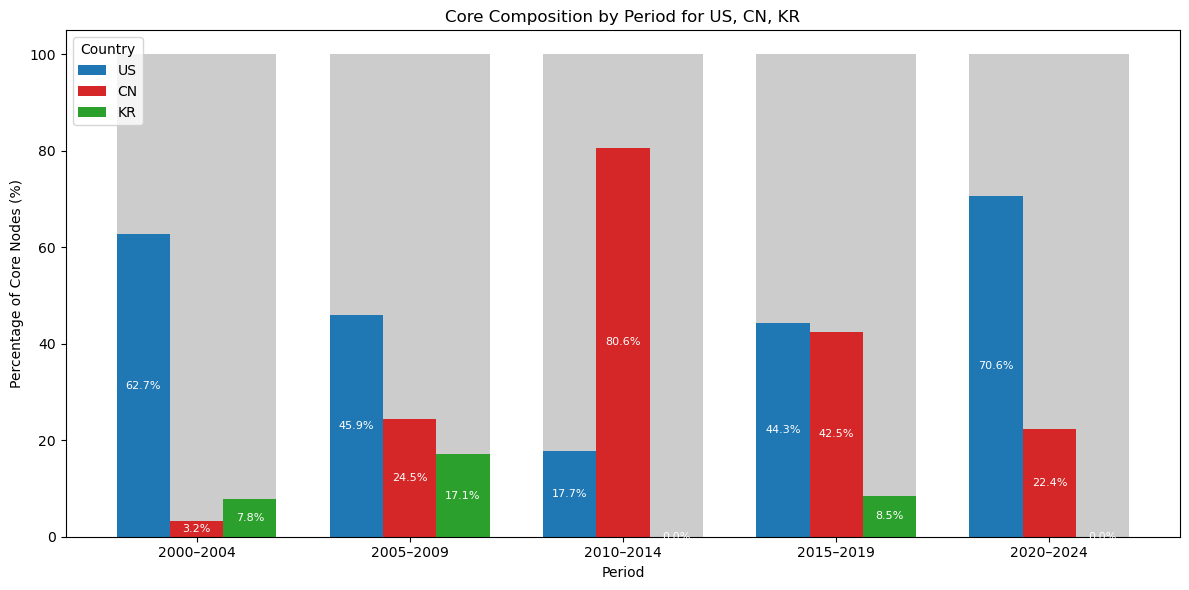

In [210]:
# Cell 9-(2): Combined stacked bar chart for US, CN, KR with country-based colors and Core-only annotations
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Focus countries and their colors
focus_countries = ["US", "CN", "KR"]
country_colors = {
    "US": "#1f77b4",  # blue
    "CN": "#d62728",  # red
    "KR": "#2ca02c",  # green
}
periphery_color = "#CCCCCC"  # light gray for remainder

# Prepare x‐axis
periods = df_summary.index.tolist()
indices = np.arange(len(periods))
width = 0.25  # space for three bars per period

fig, ax = plt.subplots(figsize=(12, 6))

# Total core nodes per period
total_cores = df_summary["Core Size"].values

for i, country in enumerate(focus_countries):
    # Country's core node counts
    core_counts = df_summary[f"{country} Core Nodes"].values
    # Convert to percentage of total cores
    core_perc = core_counts / total_cores * 100
    # Remainder up to 100%
    rem_perc = 100 - core_perc

    # Offset for each country bar
    pos = indices + (i - 1) * width

    # Draw periphery (remainder) in gray
    ax.bar(pos, rem_perc, width,
           bottom=core_perc, color=periphery_color, edgecolor='none')
    # Draw core segment in country color
    bars = ax.bar(pos, core_perc, width,
                  color=country_colors[country], label=country, edgecolor='none')

    # Annotate only core percentages
    for bar in bars:
        h = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, h / 2,
                f"{h:.1f}%",
                ha="center", va="center",
                fontsize=8, color="white")

# Axis labels and title
ax.set_xticks(indices)
ax.set_xticklabels(periods, rotation=0)
ax.set_xlabel("Period")
ax.set_ylabel("Percentage of Core Nodes (%)")
ax.set_title("Core Composition by Period for US, CN, KR")

# Legend showing countries
country_patches = [Patch(facecolor=country_colors[c], label=c) for c in focus_countries]
ax.legend(handles=country_patches, title="Country", loc="upper left")

plt.tight_layout()
plt.show()


## **9-(3): Display formatted summary table**

In [211]:
# Cell 9-(3): Display formatted summary table with corrected Core Ratio calculation and styling
import pandas as pd
from IPython.display import display

# Recompute Core Ratio (%) as Core Nodes / Core Size * 100
for country in ["US", "CN", "KR"]:
    df_summary[f"{country} Core Ratio (%)"] = (
        df_summary[f"{country} Core Nodes"] 
        / df_summary["Core Size"] * 100
    )

# Reorder and select relevant columns
cols = [
    "Total Nodes",
    "Core Size",
    "US Core Nodes", "US Core Ratio (%)",
    "CN Core Nodes", "CN Core Ratio (%)",
    "KR Core Nodes", "KR Core Ratio (%)"
]
df_display = df_summary[cols]

# Format percentage columns to one decimal place with '%' sign
percent_cols = [col for col in df_display.columns if "Ratio (%)" in col]
format_dict = {col: "{:.1f}%" for col in percent_cols}

# Apply styling with caption at bottom
styled = (
    df_display.style
    .format(format_dict)
    .set_caption("Core/Periphery Summary (US, CN, KR)")
    .set_table_styles([{
        "selector": "caption",
        "props": [("caption-side", "bottom"), ("font-weight", "bold")]
    }])
)
display(styled)
